In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import prod

/home/b/b382718/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy.stats import gaussian_kde


In [ ]:

ds_sip = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/SIP/caipeex_2mom_sip/NWP_LAM_icongrid_DOM04_20190930*Z.nc');


In [3]:

grid_caipeex = xr.open_dataset('/work/bk1415/b382718/output/caipeex/nested_run/icon_output/continental_ccn/SIP/caipeex_2mom_sip/domain4_DOM04.nc');

clon_deg = np.degrees(grid_caipeex.clon)
clat_deg = np.degrees(grid_caipeex.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([75.5, 17.5])
#print(okla_x), print(okla_y)
dx_deg = 0.5; dy_deg = 0.3
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)


73.96231325070727
78.03733091737507
15.966592379850837
20.032768784756854
75.0
76.0
17.8
17.2


(None, None)

In [4]:

window_cell = (
    (grid_caipeex.clat >= np.deg2rad(bottom_bound))
    & (grid_caipeex.clat <= np.deg2rad(top_bound))
    & (grid_caipeex.clon >= np.deg2rad(left_bound))
    & (grid_caipeex.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_caipeex.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_caipeex.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)


vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

new_grid_caipeex = reindex_grid(grid_caipeex, selected_indices, vars_to_renumber)

mask=np.isin(ds_sip['ncells'], selected_indices.cell)


window_vertex_indices :: [ 3670  3702  3718 ... 32701 32702 32703]
window_edge_indices :: [11072 11073 11074 ... 95287 95288 95289]


In [182]:

ds_sip['w_vel'] = -1.*ds_sip.omega/(9.8*ds_sip.rho)
ds_sip['tempc'] = ds_sip.temp-273.16;
ds_sip['lwc_gperm3']  = ds_sip.qc*ds_sip.rho*1.e3 # kgperm3 to gperm3
ds_sip['ciwc_gperm3'] = ds_sip.qi*ds_sip.rho*1.e3 # kgperm3 to gperm3
ds_sip['tqi'] = ds_sip.qi+ds_sip.qs+ds_sip.qg+ds_sip.qh
ds_sip['tiwc_gperm3'] = (ds_sip.qi+ds_sip.qs+ds_sip.qg+ds_sip.qh)*ds_sip.rho*1.e3 # kgperm3 to gperm3
ds_sip['cdnc_percm3'] = ds_sip.qnc*ds_sip.rho*1.e-6  # perkg to percm3
ds_sip['inc_perl'] = (ds_sip.qni+ds_sip.qns+ds_sip.qng+ds_sip.qnh)*ds_sip.rho*1.e-3 # perkg to perl

ht_avg = 1.e-3*ds_sip.z_mc.mean(dim=('time','ncells'))

tempc_avg = ds_sip.tempc.mean(dim=('time','ncells'))

In [6]:

aircraft_starttime='2019-09-30T07:00:00.000000000'
aircraft_endtime='2019-09-30T11:00:00.000000000'

#ds_nosip_new = ds_nosip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_sip_new = ds_sip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))


In [294]:

#ds_sip_new#.cdnc_percm3.max().values

In [6]:

cdnc_sip = ds_sip.cdnc_percm3
print(cdnc_sip.min().values)
print(cdnc_sip.max().values)


0.0
268.15607


In [131]:

cdnc_sip = ds_sip['cdnc_percm3'];
cdnc_sip_filt = xr.where((ds_sip.cdnc_percm3 > 0.) & (ds_sip.qc > 1.e-6), ds_sip.cdnc_percm3, np.nan);

cdnc_sip_bins = np.linspace(cdnc_sip_filt.min().values, cdnc_sip_filt.max().values, 8);
cfad_cdnc_sip = np.zeros((len(cdnc_sip_bins) - 1, len(ht_avg)));
cdnc_sip_values = cdnc_sip_filt.values;

for i in range(len(cdnc_sip_bins) - 1):
    mask = (cdnc_sip_values >= cdnc_sip_bins[i]) & (cdnc_sip_values < cdnc_sip_bins[i + 1])    
    cfad_cdnc_sip[i, :] = np.sum(mask, axis=(0,2)) / len(ds_sip.time)

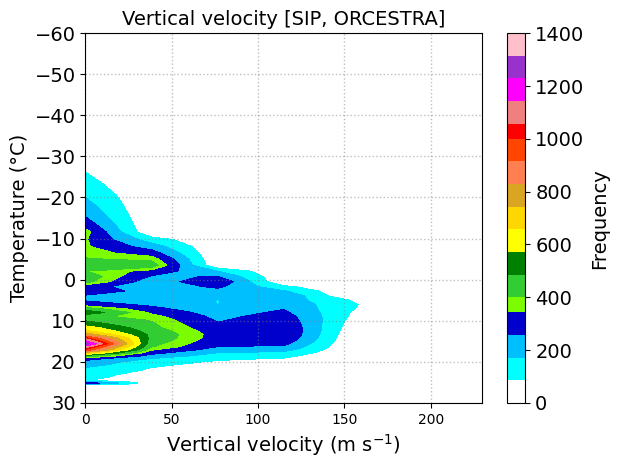

In [134]:

from matplotlib.colors import ListedColormap


fontsize = 14.;
linewidth = 1.
rotation=0
#cmap = mcolors.ListedColormap(['white', 'blue', 'green', 'yellow', 'red', 'purple'])
lev_lwc = np.linspace(0., 12000, 50)
lev_tiwc = np.linspace(0., 80000, 50)
lev_cdnc = np.linspace(0., 1400, 50)
lev_tinc = np.linspace(0., 80000, 50)
lev_wvel = np.linspace(0., 80000, 50)
lev_refl = np.linspace(0., 20000, 50)

#cfad[cfad < 0.0005]=np.nan

colors = ['white', 'cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'gold', 'goldenrod', 
          'coral', 'orangered', 'red', 'lightcoral', 'magenta', 'darkorchid', 'pink']

cmap = ListedColormap(colors)

#vmin=0, vmax=20000, levels=lev_refl

contour = plt.contourf(cdnc_sip_bins[:-1], tempc_avg, cfad_cdnc_sip.T, vmin=0, vmax=1400, levels=lev_cdnc, cmap=cmap)  
#plt.xscale('log')
#plt.xlim(-10, 5)
#plt.xticks([-3, -2, -1, 0., 1, 2, 3], rotation=rotation, fontsize=fontsize)
plt.ylim(30, -60.)
plt.yticks([30., 20., 10., 0., -10., -20., -30., -40., -50., -60.], fontsize=fontsize)
#plt.ylim(0, 16.)
#plt.yticks([0., 2., 4., 6., 8., 10., 12., 14., 16.], fontsize=fontsize)
plt.xlabel('Vertical velocity (m s$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
cbar = plt.colorbar(contour, ticks=[0, 200, 400, 600, 800, 1000, 1200, 1400], label='Frequency', orientation='vertical')
cbar.set_label('Frequency', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
plt.title('Vertical velocity [SIP, ORCESTRA]', fontsize=fontsize)
plt.grid(True, linestyle=':', color='grey', linewidth=linewidth, alpha=0.5)


In [74]:
inc_sip = ds_sip['inc_perl'];
inc_sip_filt = xr.where((ds_sip.inc_perl > 1.e-4) & (ds_sip.tqi > 1.e-9), ds_sip.inc_perl, np.nan);

inc_sip_bins = np.linspace(inc_sip_filt.min().values, inc_sip_filt.max().values, 20);
cfad_inc_sip = np.zeros((len(inc_sip_bins) - 1, len(ht_avg)));
inc_sip_values = inc_sip_filt.values;

for i in range(len(inc_sip_bins) - 1):
    mask = (inc_sip_values >= inc_sip_bins[i]) & (inc_sip_values < inc_sip_bins[i + 1])    
    cfad_inc_sip[i, :] = np.sum(mask, axis=(0,2)) / len(ds_sip.time)

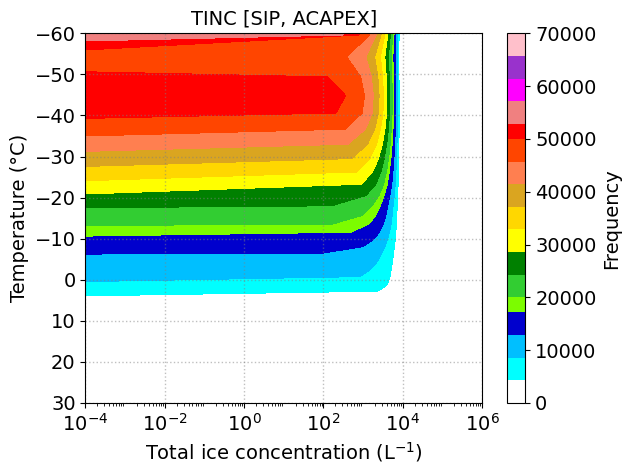

In [78]:

from matplotlib.colors import ListedColormap


fontsize = 14.;
linewidth = 1.
rotation=0
#cmap = mcolors.ListedColormap(['white', 'blue', 'green', 'yellow', 'red', 'purple'])
lev_lwc = np.linspace(0., 12000, 50)
lev_tiwc = np.linspace(0., 80000, 50)
lev_cdnc = np.linspace(0., 1400, 50)
lev_tinc = np.linspace(0., 70000, 50)
lev_wvel = np.linspace(0., 80000, 50)
lev_refl = np.linspace(0., 20000, 50)

#cfad[cfad < 0.0005]=np.nan

colors = ['white', 'cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'gold', 'goldenrod', 
          'coral', 'orangered', 'red', 'lightcoral', 'magenta', 'darkorchid', 'pink']

cmap = ListedColormap(colors)

#vmin=0, vmax=70000, levels=lev_tinc,  
#ticks=[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000],  

contour = plt.contourf(inc_sip_bins[:-1], tempc_avg, cfad_inc_sip.T, vmin=0, vmax=70000, levels=lev_tinc, cmap=cmap) 
plt.xscale('log')
plt.xlim(1.e-4, 1.e6)
plt.xticks([1.e-4, 1.e-2, 1.e0, 1.e2, 1.e4, 1.e6], rotation=rotation, fontsize=fontsize)
plt.ylim(30, -60.)
plt.yticks([30., 20., 10., 0., -10., -20., -30., -40., -50., -60.], fontsize=fontsize)
#plt.ylim(0, 16.)
#plt.yticks([0., 2., 4., 6., 8., 10., 12., 14., 16.], fontsize=fontsize)
plt.xlabel('Total ice concentration (L$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
cbar = plt.colorbar(contour, ticks=[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000], label='Frequency', orientation='vertical')
cbar.set_label('Frequency', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
plt.title('TINC [SIP, ACAPEX]', fontsize=fontsize)
plt.grid(True, linestyle=':', color='grey', linewidth=linewidth, alpha=0.5)


In [52]:
wvel_sip_bins

array([-6.02138281, -1.22667272,  3.56803737,  8.36274746, 13.15745756,
       17.95216765, 22.74687774, 27.54158783])

In [110]:
wvel_sip_bins = np.linspace(np.min(ds_sip.w_vel.values) - 1, np.max(ds_sip.w_vel.values) + 1, 15)
wvel_sip_bins

array([-7.02138281, -4.48117062, -1.94095843,  0.59925376,  3.13946595,
        5.67967813,  8.21989032, 10.76010251, 13.3003147 , 15.84052689,
       18.38073908, 20.92095126, 23.46116345, 26.00137564, 28.54158783])

In [116]:
wvel_sip_values.shape

(41, 65, 68960)

In [93]:
refl_sip = ds_sip['dbz'];
refl_sip_filt = xr.where(ds_sip.dbz > -50, ds_sip.dbz, np.nan);

refl_sip_bins = np.linspace(refl_sip_filt.min().values, refl_sip_filt.max().values, 10);
cfad_refl_sip = np.zeros((len(refl_sip_bins) - 1, len(ht_avg)));
refl_sip_values = refl_sip_filt.values;

for i in range(len(refl_sip_bins) - 1):
    mask = (refl_sip_values >= refl_sip_bins[i]) & (refl_sip_values < refl_sip_bins[i + 1])    
    cfad_refl_sip[i, :] = np.sum(mask, axis=(0,2)) / len(ds_sip.time)
    

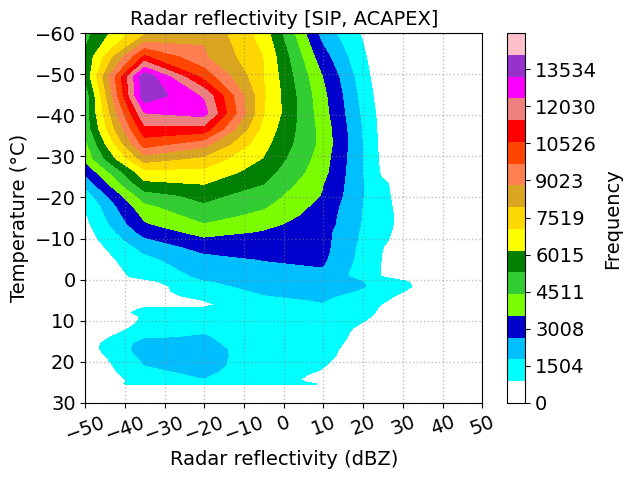

In [97]:

from matplotlib.colors import ListedColormap


fontsize = 14.;
linewidth = 1.
rotation=20
#cmap = mcolors.ListedColormap(['white', 'blue', 'green', 'yellow', 'red', 'purple'])
lev_lwc = np.linspace(0., 12000, 50)
lev_tiwc = np.linspace(0., 80000, 50)
lev_cdnc = np.linspace(0., 1400, 50)
lev_tinc = np.linspace(0., 70000, 50)
lev_wvel = np.linspace(0., 0.3, 50)
lev_refl = np.linspace(0., 15000, 400)

#cfad[cfad < 0.0005]=np.nan

colors = ['white', 'cyan', 'deepskyblue', 'mediumblue', 'lawngreen', 'limegreen', 'green', 'yellow', 'gold', 'goldenrod', 
          'coral', 'orangered', 'red', 'lightcoral', 'magenta', 'darkorchid', 'pink']

cmap = ListedColormap(colors)

#vmin=0, vmax=35000, levels=lev_tinc, 
# ticks=[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000], 

contour = plt.contourf(refl_sip_bins[:-1], tempc_avg, cfad_refl_sip.T, levels=lev_refl, cmap=cmap) 
#plt.xscale('log')
plt.xlim(-50, 50)
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], rotation=rotation, fontsize=fontsize)
plt.ylim(30, -60.)
plt.yticks([30., 20., 10., 0., -10., -20., -30., -40., -50., -60.], fontsize=fontsize)
#plt.ylim(0, 16.)
#plt.yticks([0., 2., 4., 6., 8., 10., 12., 14., 16.], fontsize=fontsize)
plt.xlabel('Radar reflectivity (dBZ)', fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
cbar = plt.colorbar(contour, label='Frequency', orientation='vertical')
cbar.set_label('Frequency', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
plt.title('Radar reflectivity [SIP, ACAPEX]', fontsize=fontsize)
plt.grid(True, linestyle=':', color='grey', linewidth=linewidth, alpha=0.5)


In [100]:

print(ds_sip.w_vel.min().values)
print(ds_sip.w_vel.max().values)

-6.021383
27.541588


In [9]:
aircraft_starttime='2019-09-30T07:00:00.000000000'
aircraft_endtime='2019-09-30T11:00:00.000000000'

ds_sip_new = ds_sip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))


In [305]:
print(filt_lwc_dn.max().values)

0.4394775


In [7]:



w_thres = 2.
###### Without SIP
# lwc gperm3
#filt_lwc_up = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_dn = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_st = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.lwc_gperm3, np.nan)

#lwc_up_nosip = filt_lwc_up.mean(dim=('time','ncells'))
#lwc_dn_nosip = filt_lwc_dn.mean(dim=('time','ncells'))
#lwc_st_nosip = filt_lwc_st.mean(dim=('time','ncells'))

#tempc_nosip = ds_nosip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
#filt_tiwc_up = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_dn = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_st = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.tiwc_gperm3, np.nan)

#tiwc_up_nosip = filt_tiwc_up.mean(dim=('time','ncells'))
#tiwc_dn_nosip = filt_tiwc_dn.mean(dim=('time','ncells'))
#tiwc_st_nosip = filt_tiwc_st.mean(dim=('time','ncells'))

# CDNC percm3
#filt_cdnc_up = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_dn = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_st = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.cdnc_percm3, np.nan)

#cdnc_up_nosip = filt_cdnc_up.mean(dim=('time','ncells'))
#cdnc_dn_nosip = filt_cdnc_dn.mean(dim=('time','ncells'))
#cdnc_st_nosip = filt_cdnc_st.mean(dim=('time','ncells'))

# inc gperm3
#filt_inc_up = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_dn = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.inc_perl, np.nan)
#filt_inc_st = xr.where((ds_nosip_new.inc_perl > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.inc_perl, np.nan)

#inc_up_nosip = filt_inc_up.mean(dim=('time','ncells'))
#inc_dn_nosip = filt_inc_dn.mean(dim=('time','ncells'))
#inc_st_nosip = filt_inc_st.mean(dim=('time','ncells'))


###### With SIP
# lwc gperm3
filt_lwc_up = xr.where((ds_sip_new.lwc_gperm3 > 1.e-9) & (ds_sip_new.w_vel > w_thres), ds_sip_new.lwc_gperm3, np.nan)
filt_lwc_dn = xr.where((ds_sip_new.lwc_gperm3 > 1.e-9) & (ds_sip_new.w_vel < -1.*w_thres), ds_sip_new.lwc_gperm3, np.nan)
filt_lwc_st = xr.where((ds_sip_new.lwc_gperm3 > 1.e-9) & (np.abs(ds_sip_new.w_vel) < w_thres), ds_sip_new.lwc_gperm3, np.nan)

lwc_up_sip = filt_lwc_up.mean(dim=('time','ncells'))
lwc_dn_sip = filt_lwc_dn.mean(dim=('time','ncells'))
lwc_st_sip = filt_lwc_st.mean(dim=('time','ncells'))

tempc_sip = ds_sip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
filt_tiwc_up = xr.where((ds_sip_new.tiwc_gperm3 > 1.e-6) & (ds_sip_new.w_vel > w_thres), ds_sip_new.tiwc_gperm3, np.nan)
filt_tiwc_dn = xr.where((ds_sip_new.tiwc_gperm3 > 1.e-6) & (ds_sip_new.w_vel < -1.*w_thres), ds_sip_new.tiwc_gperm3, np.nan)
filt_tiwc_st = xr.where((ds_sip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_sip_new.w_vel) < w_thres), ds_sip_new.tiwc_gperm3, np.nan)

tiwc_up_sip = filt_tiwc_up.mean(dim=('time','ncells'))
tiwc_dn_sip = filt_tiwc_dn.mean(dim=('time','ncells'))
tiwc_st_sip = filt_tiwc_st.mean(dim=('time','ncells'))

# CDNC percm3
filt_cdnc_up = xr.where((ds_sip_new.cdnc_percm3 > 1.e-6) & (ds_sip_new.w_vel > w_thres), ds_sip_new.cdnc_percm3, np.nan)
filt_cdnc_dn = xr.where((ds_sip_new.cdnc_percm3 > 1.e-6) & (ds_sip_new.w_vel < -1.*w_thres), ds_sip_new.cdnc_percm3, np.nan)
filt_cdnc_st = xr.where((ds_sip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_sip_new.w_vel) < w_thres), ds_sip_new.cdnc_percm3, np.nan)

cdnc_up_sip = filt_cdnc_up.mean(dim=('time','ncells'))
cdnc_dn_sip = filt_cdnc_dn.mean(dim=('time','ncells'))
cdnc_st_sip = filt_cdnc_st.mean(dim=('time','ncells'))


# inc gperm3
filt_inc_up = xr.where((ds_sip_new.inc_perl > 1.e-6) & (ds_sip_new.w_vel > w_thres), ds_sip_new.inc_perl, np.nan)
filt_inc_dn = xr.where((ds_sip_new.inc_perl > 1.e-6) & (ds_sip_new.w_vel < -1.*w_thres), ds_sip_new.inc_perl, np.nan)
filt_inc_st = xr.where((ds_sip_new.inc_perl > 1.e-6) & (np.abs(ds_sip_new.w_vel) < w_thres), ds_sip_new.inc_perl, np.nan)

inc_up_sip = filt_inc_up.mean(dim=('time','ncells'))
inc_dn_sip = filt_inc_dn.mean(dim=('time','ncells'))
inc_st_sip = filt_inc_st.mean(dim=('time','ncells'))

In [14]:

lfr_pim_max_sip = ds_sip.lfr_con_pim.max(dim='ncells')
lfr_iwp_max_sip = ds_sip.lfr_con_iwp.max(dim='ncells')
lfr_gev_max_sip = ds_sip.lfr_con_gev.max(dim='ncells')
lfr_graupm_max_sip = ds_sip.lfr_con_uv51.max(dim='ncells')  
lfr_hailm_max_sip = ds_sip.lfr_con_uv52.max(dim='ncells')
lfr_uv10_max_sip = ds_sip.lfr_con_uv10.max(dim='ncells')
lfr_prh_max_sip = ds_sip.lfr_con_prh.max(dim='ncells')
lfr_prw_max_sip = ds_sip.lfr_con_prw.max(dim='ncells')
lpi_max_sip = ds_sip.lpi.max(dim='ncells')


In [212]:
data_pip.Nt_percm3perum

Nt_percm3perum  Nt_percm3perum  Nt_percm3perum  Nt_percm3perum  \
0                 0.0             0.0             0.0             0.0   
1                 0.0             0.0             0.0             0.0   
2                 0.0             0.0             0.0             0.0   
3                 0.0             0.0             0.0             0.0   
4                 0.0             0.0             0.0             0.0   
...               ...             ...             ...             ...   
11849             0.0             0.0             0.0             0.0   
11850             0.0             0.0             0.0             0.0   
11851             0.0             0.0             0.0             0.0   
11852             0.0             0.0             0.0             0.0   
11853             0.0             0.0             0.0             0.0   

       Nt_percm3perum  Nt_percm3perum  Nt_percm3perum  Nt_percm3perum  \
0                 0.0             0.0             0.0             0.0   
1                 0.0             0.0             0.0             0.0   
2                 0.0             0.0             0.0             0.0   
3                 0.0             0.0             0.0             0.0   
4                 0.0             0.0             0.0             0.0   
...               ...             ...             ...             ...   
11849             0.0             0.0             0.0             0.0   
11850             0.0             0.0             0.0             0.0   
11851             0.0             0.0             0.0             0.0   
11852             0.0             0.0             0.0             0.0   
11853             0.0             0.0             0.0             0.0   

       Nt_percm3perum  Nt_percm3perum  ...  Nt_percm3perum  Nt_percm3perum  \
0                 0.0             0.0  ...             0.0             0.0   
1                 0.0             0.0  ...             0.0             0.0   
2                 0.0             0.0  ...             0.0             0.0   
3                 0.0             0.0  ...             0.0             0.0   
4                 0.0             0.0  ...             0.0             0.0   
...               ...             ...  ...             ...             ...   
11849             0.0             0.0  ...             0.0             0.0   
11850             0.0             0.0  ...             0.0             0.0   
11851             0.0             0.0  ...             0.0             0.0   
11852             0.0             0.0  ...             0.0             0.0   
11853             0.0             0.0  ...             0.0             0.0   

       Nt_percm3perum  Nt_percm3perum  Nt_percm3perum  Nt_percm3perum  \
0                 0.0             0.0             0.0             0.0   
1                 0.0             0.0             0.0             0.0   
2                 0.0             0.0             0.0             0.0   
3                 0.0             0.0             0.0             0.0   
4                 0.0             0.0             0.0             0.0   
...               ...             ...             ...             ...   
11849             0.0             0.0             0.0             0.0   
11850             0.0             0.0             0.0             0.0   
11851             0.0             0.0             0.0             0.0   
11852             0.0             0.0             0.0             0.0   
11853             0.0             0.0             0.0             0.0   

       Nt_percm3perum  Nt_percm3perum  Nt_percm3perum  Nt_percm3perum  
0                 0.0             0.0             0.0             0.0  
1                 0.0             0.0             0.0             0.0  
2                 0.0             0.0             0.0             0.0  
3                 0.0             0.0             0.0             0.0  
4                 0.0             0.0             0.0             0.0  
...    

In [207]:

tm_range = slice(2743, 2744)
print(data_pip.time[tm_range])
#print(data_pip.Nt_percm3perum[1979:1980].values)
print('value in each bin [percm3] > 400µm :: ',data_pip.iloc[tm_range, 5:61].values)
print()
print('SUM  > 400µm  :: ',np.sum(100.*data_pip.iloc[tm_range, 5:61].values))

2743    28584
Name: time, dtype: int64
value in each bin [percm3] > 400µm ::  [[2.8814   2.1036   1.7712   1.1858   0.75485  0.49991  0.34621  0.24643
  0.15625  0.18024  0.14153  0.065045 0.073844 0.037742 0.0772   0.063196
  0.080876 0.074564 0.050952 0.01742  0.071512 0.018361 0.028307 0.029115
  0.059944 0.051467 0.04246  0.032872 0.056613 0.046852 0.072789 0.012581
  0.039194 0.067936 0.056613 0.029537 0.01544  0.097052 0.033968 0.035756
  0.16984  0.019981 0.02123  0.       0.048526 0.       0.028307 0.
  0.033968 0.11323  0.04246  0.       0.11323  0.       0.       0.11323 ]]

SUM  > 400µm  ::  1241.063


In [198]:

## PIP
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/CIP/correctedPbPCIPSizeSpectraCAIPEX20190930.txt'
data_cip = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_cip.columns = ['time'] + ['Nt_percm3perum']*62 + ['mass_gpercm']* (data_cip.shape[1]-63) # cols 2-63: n_conc, & remaining 62 columns: mass
##

## PIP
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/PIP/correctedPIPSizeSpectraCAIPEX20190930.txt'
data_pip = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_pip.columns = ['time'] + ['Nt_percm3perum']*62 + ['mass_gpercm']* (data_pip.shape[1]-63) # cols 2-63: n_conc, & remaining 62 columns: mass
##

## CIP
diam_cip_end_bin = [15., 30., 45., 60., 75., 90., 105., 120., 135., 150.,
                    165., 180., 195., 210., 225., 240., 255., 270., 285., 300.,
                    315., 330., 345., 360., 375., 390., 405., 420., 435., 450., 
                    465., 480., 495., 510., 525., 540., 555., 570., 585., 600.,
                    615., 630., 645., 660., 675., 690., 705., 720., 735., 750.,
                    765., 780., 795., 810., 825., 840., 855., 870., 885., 900.,
                    915., 930.]
##

## PIP
diam_pip_end_bin = [100., 200., 300., 400., 500., 600., 700., 800., 900., 1000.,
                    1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000.,
                    2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800., 2900., 3000.,
                    3100., 3200., 3300., 3400., 3500., 3600., 3700., 3800., 3900., 4000.,
                    4100., 4200., 4300., 4400., 4500., 4600., 4700., 4800., 4900., 5000.,
                    5100., 5200., 5300., 5400., 5500., 5600., 5700., 5800., 5900., 6000.,
                    6100., 6200.]
## 

#diam_cip_width_um = np.diff(diam_cip_bin_um)
#diam_cip_width_cm = np.diff(diam_cip_bin_cm)

## CIP
diam_cip_bin_um = np.array(diam_cip_end_bin)
diam_cip_bin_cm = 1.e-4*np.array(diam_cip_end_bin)

nt_cip_percm3perum = data_cip.iloc[:,1:63].values
mt_cip_gpercm = data_cip.iloc[:,63:].values
##

## PIP
diam_pip_bin_um = np.array(diam_pip_end_bin)
diam_pip_bin_m = 1.e-6*diam_pip_bin_um
diam_pip_bin_cm = 1.e-4*np.array(diam_pip_end_bin)

nt_pip_percm3percm = data_pip.iloc[:,1:63].values
nt_pip_perm3perm = 1.e5*data_pip.iloc[:,1:63].values  # only for check (From Dr. Sachin Patade, netcdf file screenshot)
mt_pip_gpercm = data_pip.iloc[:,63:].values
##

##============================================ CIP
cip_nt_mask = (nt_cip_percm3perum > 0.)
mask_cip_diam_um = (np.array(diam_cip_end_bin) > 400.)
cip_mt_mask = (mt_cip_gpercm > 0.) 

diam_cip_bin_width_um = 15.    # µm
diam_cip_bin_width_cm = 15.e-4 # cm

nice_cip_percm3 = np.where(cip_nt_mask & mask_cip_diam_um, nt_cip_percm3perum* diam_cip_bin_width_um, np.nan)
#mice_cip_gperm3 = np.where(cip_mt_mask & mask_cip_diam_um, mt_cip_gpercm/(diam_cip_bin_width_cm**2.), np.nan)

nice_cip_percm3 = np.nansum(nice_cip_percm3, axis=1)
#mice_cip_percm3 = np.nansum(mice_cip_gperm3, axis=1)

nice400um_cip_perl = 1.e3*nice_cip_percm3

# Store required variables in as a new dataset  
ds_cip = pd.DataFrame()
ds_cip['time'] = data_cip['time']
ds_cip['ni400um_cip_perl'] = pd.Series(nice400um_cip_perl)
##============================================

##============================================ PIP
pip_nt_mask = (nt_pip_percm3percm > 0.) #& (nt_pip_percm3perum < 1.0) 
mask_pip_diam_um = (np.array(diam_pip_end_bin) > 400.)
mask_pip_diam_m = (diam_pip_bin_m > 400.e-6)
mask_pip_diam_cm = (diam_pip_bin_m > 400.e-4)
pip_mt_mask = (mt_pip_gpercm > 0.) 

diam_pip_bin_width_m = 100*1.e-6 # m
diam_pip_bin_width_um = 100. # µm
diam_pip_bin_width_cm = 100*1.e-4 # cm

nice_pip_percm3 = np.where(pip_nt_mask & mask_pip_diam_m, nt_pip_percm3percm * diam_pip_bin_width_cm, np.nan)
nice_pip_perm3 = np.where(pip_nt_mask & mask_pip_diam_m, nt_pip_perm3perm * diam_pip_bin_width_m, np.nan)  # only for check
#mice_pip_gperm3 = np.where(pip_mt_mask & mask_pip_diam_um, mt_pip_gpercm/(diam_pip_bin_width_cm**2.), np.nan)

nice_pip_percm3 = np.nansum(nice_pip_percm3, axis=1)
nice_pip_perm3 = np.nansum(nice_pip_perm3, axis=1)
#mice_cip_percm3 = np.nansum(mice_cip_gperm3, axis=1)

nice400um_pip_perl = 1.e3*nice_pip_percm3

# Store required variables in as a new dataset  
ds_pip = pd.DataFrame()
ds_pip['time'] = data_pip['time']
ds_pip['ni400um_pip_perl'] = pd.Series(nice400um_pip_perl)
##============================================

#plt.plot(ds_cip.time,ds_cip.nice400um_cip_perl)

In [124]:
diam_pip_bin_cm

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62])

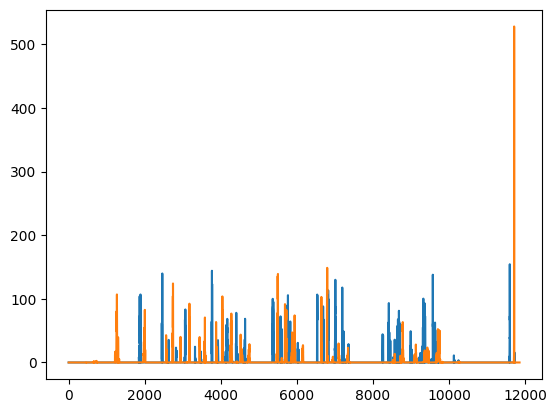

In [199]:
#plt.plot(nice400um_cip_perl)
#plt.plot(1.e-3*nice_pip_perm3)
#plt.plot(nt_pip_percm3percm)
plt.plot(ds_cip.ni400um_cip_perl)
plt.plot(ds_pip.ni400um_pip_perl)
#plt.ylim(1.e0,2.e6)
#plt.plot(nt_cip_percm3perum)
#plt.plot(nice_cip_percm3)

In [200]:

# Flight data
file_path = '/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/aa_CIPcorrectedprocessed1HzdataCAIPEX20190930.txt'
data_v2 = pd.read_csv(file_path, sep='\s+', header=None, skiprows=1)

data_v2.columns = ['time', 'alt', 'lon', 'lat', 'air_speed', 
                   'air_temp', 'pres', 'rel_hum', 'wind_spped', 'wind_dir',
                   'vert_vel', 'num_conc_ccp_cdp', 'lwc_conc_ccp_cdp', 'mean_vol_diam_ccp_cdp', 'ccn200ass',
                   'ccn200anumconc', 'ccn200bss', 'ccn200bnumconc', 'num_conc_cdp', 'lwc_conc_cdp',
                   'mean_vol_diam_cdp', 'num_conc_cip', 'lwc_conc_cip', 'mean_vol_diam_cip', 'num_conc_pcasp',
                   'mass_conc_pcasp', 'mean_vol_diam_pcasp', 'num_conc_pip', 'lwc_conc_pip', 'mean_vol_diam_pip', 
                   'num_conc_sp2', 'mass_conc_sp2', 'mean_vol_diam_sp2', 'num_conc_sp2rbc', 'mass_conc_sp2rbc',  
                   'mean_vol_diam_sp2rbc', 'num_conc_uhsas', 'mass_conc_uhsas', 'mean_vol_diam_uhsas', 'lwc_300']

#df_v2 = pd.DataFrame(data_v2)
#df_v2['num_conc_cip'] = pd.to_numeric(df_v2['num_conc_cip'], errors='coerce')
data_v2['tempc'] = data_v2['air_temp']
ds_v2 = data_v2
ds_v2['nice_cip_up'] = np.where(ds_v2.num_conc_cip > 0., ds_v2.num_conc_cip, np.nan)

# CDNC
ds_v2['cdnc_cdp_up_percm3'] = np.where((ds_v2.num_conc_cdp > 5.) & (ds_v2.vert_vel > 2.), ds_v2.num_conc_cdp, np.nan)
ds_v2['cdnc_cdp_dn_percm3'] = np.where((ds_v2.num_conc_cdp > 5.) & (ds_v2.vert_vel < -2.), ds_v2.num_conc_cdp, np.nan)
ds_v2['cdnc_cdp_st_percm3'] = np.where((ds_v2.num_conc_cdp > 5.) & (np.abs(ds_v2.vert_vel) < 2.), ds_v2.num_conc_cdp, np.nan)

# LWC
ds_v2['lwc_cdp_up_gperm3'] = np.where((ds_v2.lwc_conc_cdp > 1.e-6) & (ds_v2.vert_vel > 2.) & (ds_v2.num_conc_cdp > 5.), ds_v2.lwc_conc_cdp, np.nan)
ds_v2['lwc_cdp_dn_gperm3'] = np.where((ds_v2.lwc_conc_cdp > 1.e-6) & (ds_v2.vert_vel < -2.) & (ds_v2.num_conc_cdp > 5.), ds_v2.lwc_conc_cdp, np.nan)
ds_v2['lwc_cdp_st_gperm3'] = np.where((ds_v2.lwc_conc_cdp > 1.e-6) & (np.abs(ds_v2.vert_vel) < 2.) & (ds_v2.num_conc_cdp > 5.), ds_v2.lwc_conc_cdp, np.nan)

temp_bin = np.arange(-30, 30, 4)
temp_bin = np.sort(temp_bin)

ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)
ds_v2['temp_bin'] = pd.cut(ds_v2['air_temp'], bins=np.append(temp_bin, np.inf), labels=temp_bin)


ds_v2 = ds_v2.dropna(subset=['temp_bin'])

ds_v2['temp_bin'] = ds_v2['temp_bin'].astype(float)

## Combine ds_v2 and ds_cip data for ds_v2.time=ds_cip.time
##=========== PIP
ds_v2_cip_comb = pd.merge(ds_v2, ds_cip, on='time', how='inner')

##=========== PIP
ds_v2_pip_comb = pd.merge(ds_v2, ds_pip, on='time', how='inner')

# TINC
##=========== CIP
ds_v2_cip_comb['ni400um_cip_up_perl'] = np.where((ds_v2_cip_comb.ni400um_cip_perl > 1.e-3) & (ds_v2_cip_comb.vert_vel > 2.), 
                                        ds_v2_cip_comb.ni400um_cip_perl, np.nan)
ds_v2_cip_comb['ni400um_cip_dn_perl'] = np.where((ds_v2_cip_comb.ni400um_cip_perl > 1.e-3) & (ds_v2_cip_comb.vert_vel < -2.), 
                                        ds_v2_cip_comb.ni400um_cip_perl, np.nan)
ds_v2_cip_comb['ni400um_cip_st_perl'] = np.where((ds_v2_cip_comb.ni400um_cip_perl > 1.e-3) & (np.abs(ds_v2_cip_comb.vert_vel) < 2.), 
                                        ds_v2_cip_comb.ni400um_cip_perl, np.nan)

##=========== PIP
ds_v2_pip_comb['ni400um_pip_up_perl'] = np.where((ds_v2_pip_comb.ni400um_pip_perl > 1.e-3) & (ds_v2_pip_comb.vert_vel > 2.), 
                                        ds_v2_pip_comb.ni400um_pip_perl, np.nan)
ds_v2_pip_comb['ni400um_pip_dn_perl'] = np.where((ds_v2_pip_comb.ni400um_pip_perl > 1.e-3) & (ds_v2_pip_comb.vert_vel < -2.), 
                                        ds_v2_pip_comb.ni400um_pip_perl, np.nan)
ds_v2_pip_comb['ni400um_pip_st_perl'] = np.where((ds_v2_pip_comb.ni400um_pip_perl > 1.e-3) & (np.abs(ds_v2_pip_comb.vert_vel) < 2.), 
                                        ds_v2_pip_comb.ni400um_pip_perl, np.nan)


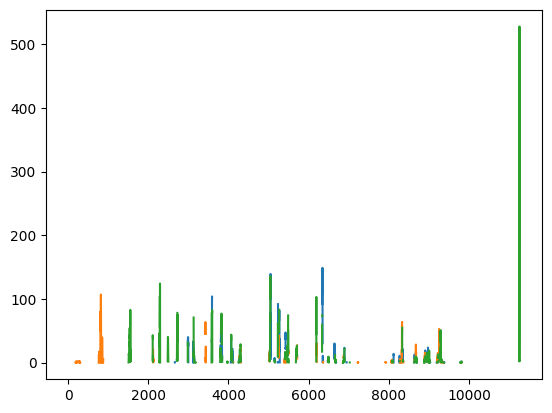

In [128]:
plt.plot(ds_v2_pip_comb.ni400um_pip_up_perl)
plt.plot(ds_v2_pip_comb.ni400um_pip_dn_perl)
plt.plot(ds_v2_pip_comb.ni400um_pip_st_perl)


/tmp/ipykernel_3649621/452782729.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_3649621/452782729.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_3649621/452782729.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)


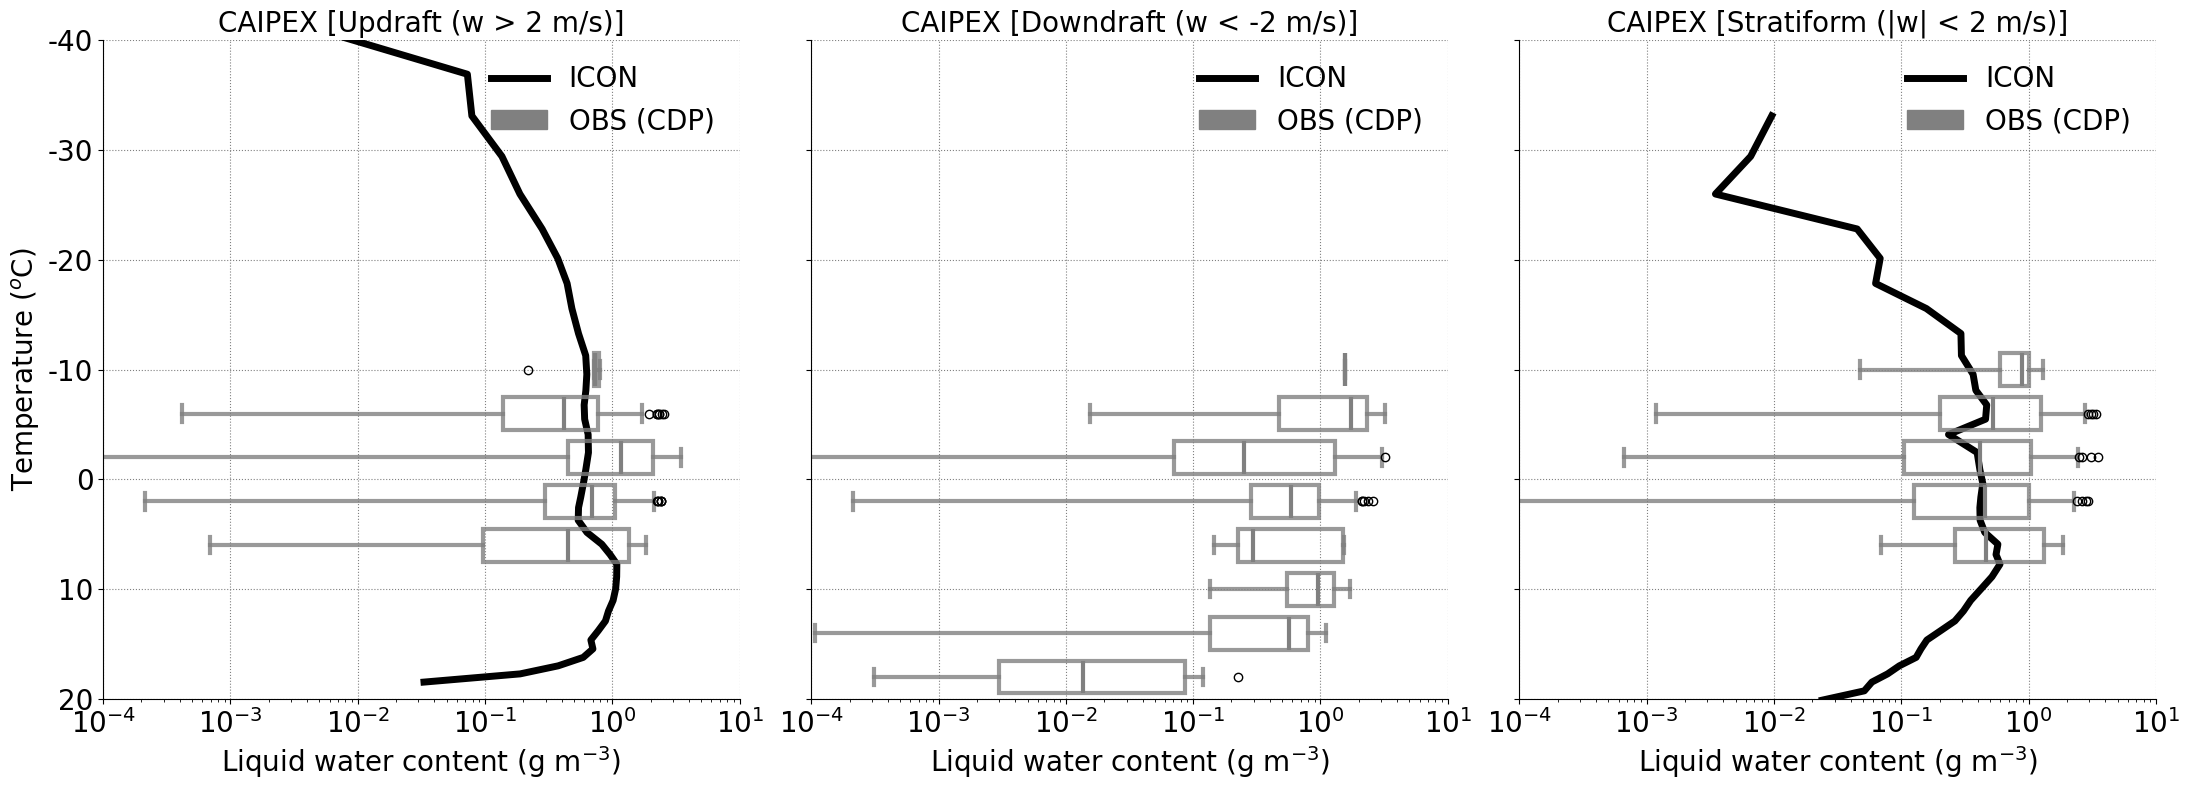

In [85]:


df_v2 = pd.DataFrame(ds_v2)


temp_cdp_bin = np.arange(-30, 30, 4)
temp_cdp_bin = np.sort(temp_cdp_bin)

df_v2['temp_cdp_bin'] = np.digitize(df_v2['tempc'], bins=temp_cdp_bin, right=False)

bin_edges = np.concatenate([temp_cdp_bin - 2, [temp_cdp_bin[-1] + 2]])  
df_v2['temp_bin'] = bin_edges[df_v2['temp_cdp_bin']]

# LWC
df_lwc_up_cdp = df_v2[['lwc_cdp_up_gperm3', 'temp_bin']].dropna()
df_lwc_dn_cdp = df_v2[['lwc_cdp_dn_gperm3', 'temp_bin']].dropna()
df_lwc_st_cdp = df_v2[['lwc_cdp_st_gperm3', 'temp_bin']].dropna()

df_lwc_up_cdp = df_lwc_up_cdp.dropna(subset=['temp_bin'])
df_lwc_dn_cdp = df_lwc_dn_cdp.dropna(subset=['temp_bin'])
df_lwc_st_cdp = df_lwc_st_cdp.dropna(subset=['temp_bin'])

lwc_cdp_up_by_bin = [df_lwc_up_cdp[df_lwc_up_cdp['temp_bin'] == temp]['lwc_cdp_up_gperm3'].values for temp in bin_edges]
lwc_cdp_dn_by_bin = [df_lwc_dn_cdp[df_lwc_dn_cdp['temp_bin'] == temp]['lwc_cdp_dn_gperm3'].values for temp in bin_edges]
lwc_cdp_st_by_bin = [df_lwc_st_cdp[df_lwc_st_cdp['temp_bin'] == temp]['lwc_cdp_st_gperm3'].values for temp in bin_edges]

# CDNC
df_cdnc_up_cdp = df_v2[['cdnc_cdp_up_percm3', 'temp_bin']].dropna()
df_cdnc_dn_cdp = df_v2[['cdnc_cdp_dn_percm3', 'temp_bin']].dropna()
df_cdnc_st_cdp = df_v2[['cdnc_cdp_st_percm3', 'temp_bin']].dropna()

df_cdnc_up_cdp = df_cdnc_up_cdp.dropna(subset=['temp_bin'])
df_cdnc_dn_cdp = df_cdnc_dn_cdp.dropna(subset=['temp_bin'])
df_cdnc_st_cdp = df_cdnc_st_cdp.dropna(subset=['temp_bin'])

cdnc_cdp_up_by_bin = [df_cdnc_up_cdp[df_cdnc_up_cdp['temp_bin'] == temp]['cdnc_cdp_up_percm3'].values for temp in bin_edges]
cdnc_cdp_dn_by_bin = [df_cdnc_dn_cdp[df_cdnc_dn_cdp['temp_bin'] == temp]['cdnc_cdp_dn_percm3'].values for temp in bin_edges]
cdnc_cdp_st_by_bin = [df_cdnc_st_cdp[df_cdnc_st_cdp['temp_bin'] == temp]['cdnc_cdp_st_percm3'].values for temp in bin_edges]


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEX [Updraft (w > 2 m/s)]', 'CAIPEX [Downdraft (w < -2 m/s)]', 'CAIPEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 3;
width=3
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(lwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 1:
        ax.plot(lwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
    elif i == 2:
        ax.plot(lwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-4, 1.e1)
    ax.set_xticklabels([1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(20, -40)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Liquid water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch = mpatches.Patch(color='grey', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch], frameon=False, loc='upper right', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3649621/1003672378.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_3649621/1003672378.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_3649621/1003672378.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)


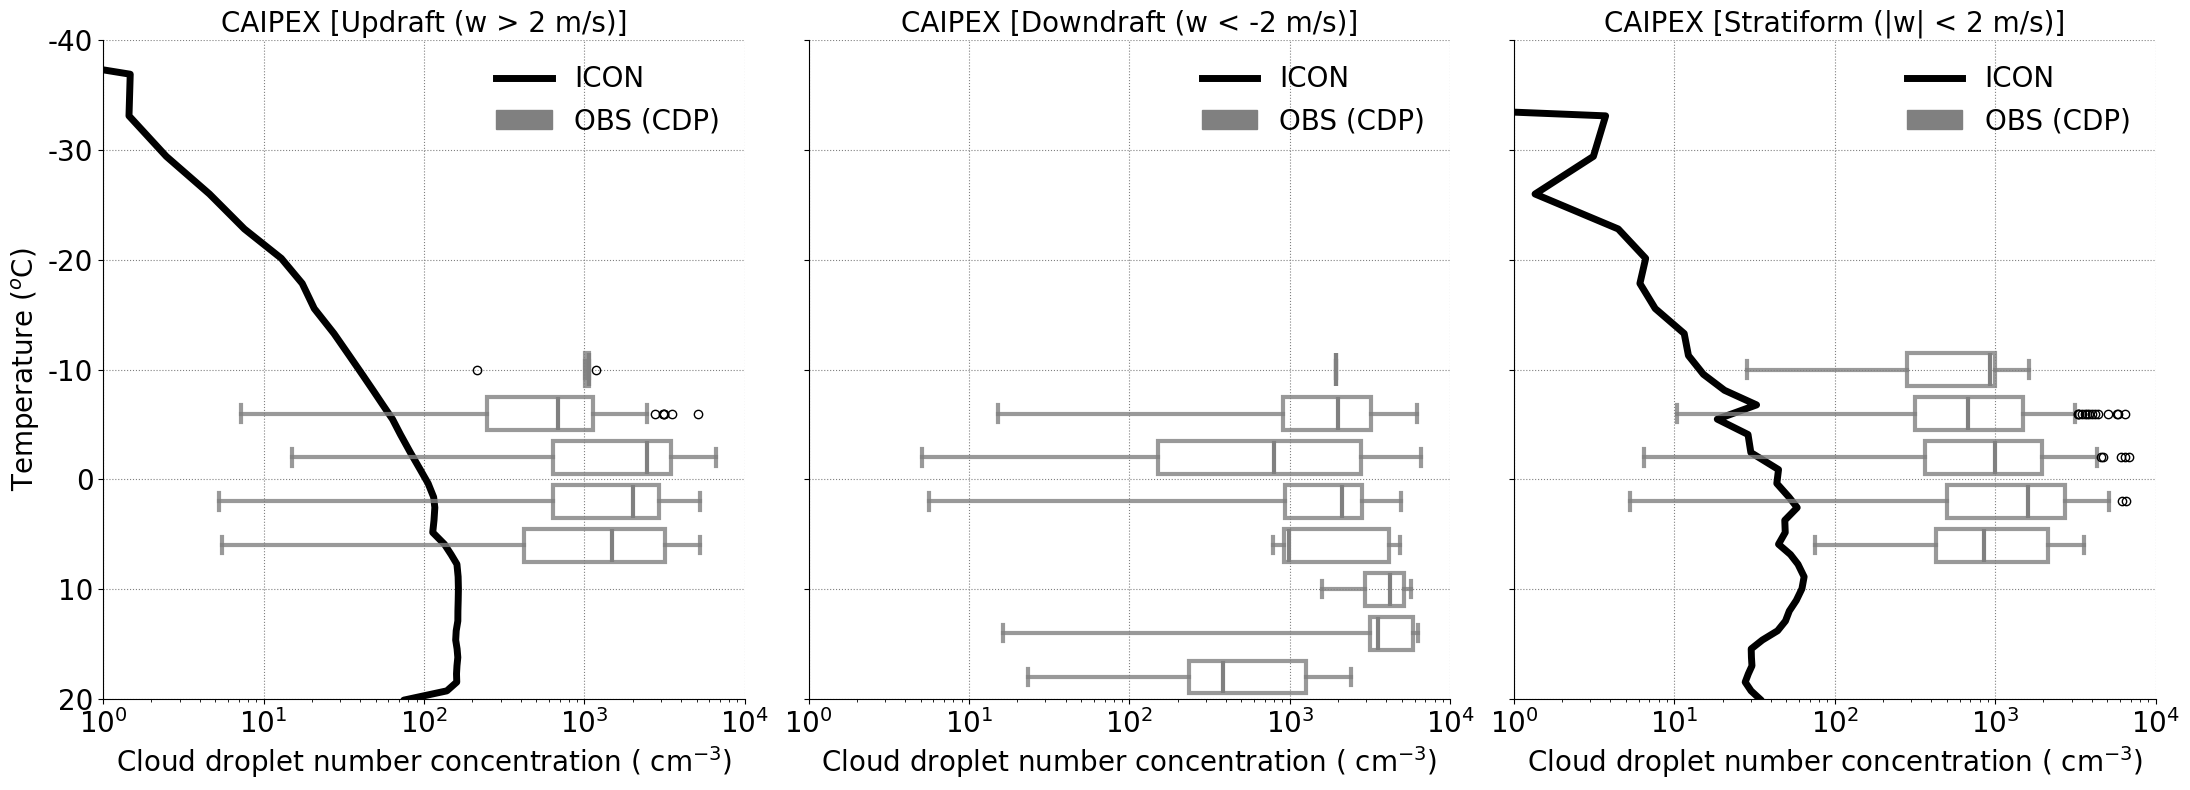

In [84]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEX [Updraft (w > 2 m/s)]', 'CAIPEX [Downdraft (w < -2 m/s)]', 'CAIPEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 3;
width=3
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        ax.plot(cdnc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_cdp_up_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
        
    elif i == 1:
        ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_cdp_dn_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
    elif i == 2:
        ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_cdp_st_by_bin[:-1], positions=temp_cdp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e0, 1.e4)
    ax.set_xticklabels([1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
    ax.set_ylim(20, -40)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Cloud droplet number concentration ( cm$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch = mpatches.Patch(color='grey', label='OBS (CDP)')

    ax.legend(handles=handles + [obs_patch], frameon=False, loc='upper right', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([20, 10, 0, -10, -20, -30, -40])
axes[0].set_yticklabels(['20', '10', '0', '-10', '-20', '-30', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3649621/2901737904.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_3649621/2901737904.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_3649621/2901737904.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)


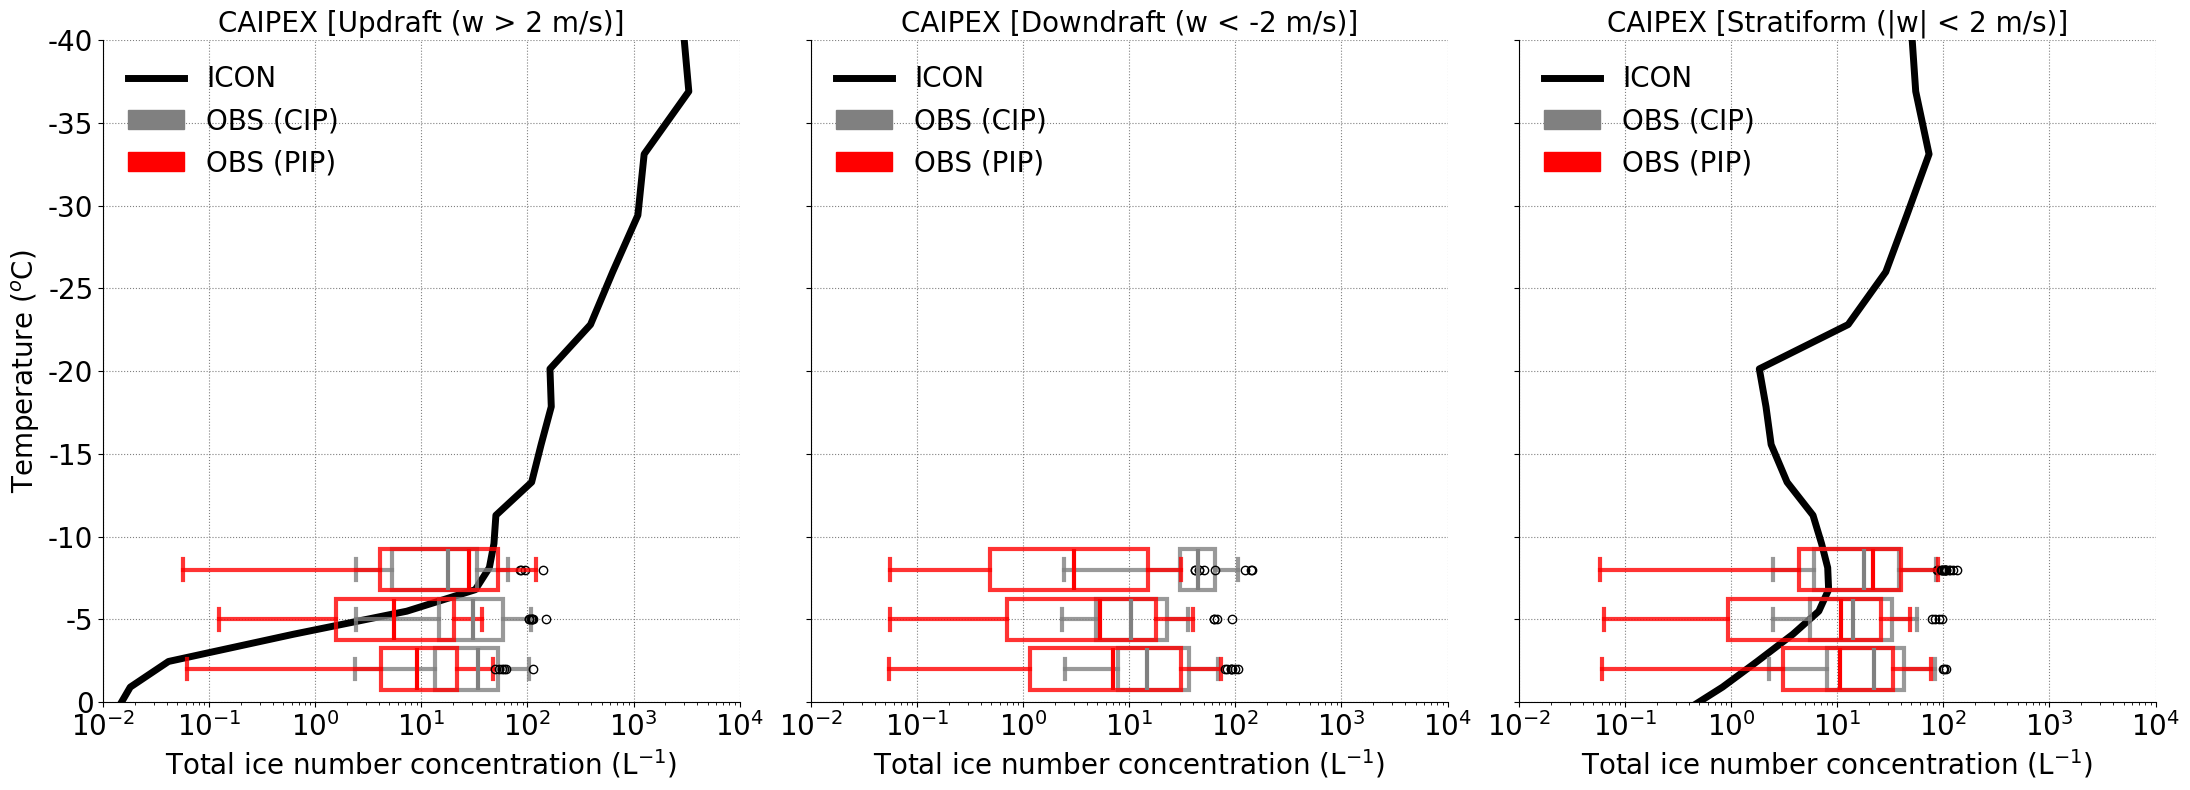

In [204]:

## Total ice number concentrations (CIP & PIP > 400µm)
##=============== CIP
df_v2_cip_comb = pd.DataFrame(ds_v2_cip_comb)

temp_cip_bin = np.arange(-20, 0, 3)
temp_cip_bin = np.sort(temp_cip_bin)

df_v2_cip_comb['temp_cip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_cip_bin, right=False)

bin_edges = np.concatenate([temp_cip_bin - 2, [temp_cip_bin[-1] + 2]])  
df_v2_cip_comb['temp_bin'] = bin_edges[df_v2_cip_comb['temp_cip_bin']]

# TINC
df_nice_up_cip = df_v2_cip_comb[['ni400um_cip_up_perl', 'temp_bin']].dropna()
df_nice_dn_cip = df_v2_cip_comb[['ni400um_cip_dn_perl', 'temp_bin']].dropna()
df_nice_st_cip = df_v2_cip_comb[['ni400um_cip_st_perl', 'temp_bin']].dropna()

df_nice_up_cip = df_nice_up_cip.dropna(subset=['temp_bin'])
df_nice_dn_cip = df_nice_dn_cip.dropna(subset=['temp_bin'])
df_nice_st_cip = df_nice_st_cip.dropna(subset=['temp_bin'])

nice_cip_up_by_bin = [df_nice_up_cip[df_nice_up_cip['temp_bin'] == temp]['ni400um_cip_up_perl'].values for temp in bin_edges]
nice_cip_dn_by_bin = [df_nice_dn_cip[df_nice_dn_cip['temp_bin'] == temp]['ni400um_cip_dn_perl'].values for temp in bin_edges]
nice_cip_st_by_bin = [df_nice_st_cip[df_nice_st_cip['temp_bin'] == temp]['ni400um_cip_st_perl'].values for temp in bin_edges]


##=============== PIP
df_v2_pip_comb = pd.DataFrame(ds_v2_pip_comb)

temp_pip_bin = np.arange(-20, 0, 3)
temp_pip_bin = np.sort(temp_pip_bin)

df_v2_pip_comb['temp_pip_bin'] = np.digitize(df_v2_cip_comb['tempc'], bins=temp_pip_bin, right=False)

bin_edges = np.concatenate([temp_pip_bin - 2, [temp_pip_bin[-1] + 2]])  
df_v2_pip_comb['temp_bin'] = bin_edges[df_v2_pip_comb['temp_pip_bin']]

# TINC
df_nice_up_pip = df_v2_pip_comb[['ni400um_pip_up_perl', 'temp_bin']].dropna()
df_nice_dn_pip = df_v2_pip_comb[['ni400um_pip_dn_perl', 'temp_bin']].dropna()
df_nice_st_pip = df_v2_pip_comb[['ni400um_pip_st_perl', 'temp_bin']].dropna()

df_nice_up_pip = df_nice_up_pip.dropna(subset=['temp_bin'])
df_nice_dn_pip = df_nice_dn_pip.dropna(subset=['temp_bin'])
df_nice_st_pip = df_nice_st_pip.dropna(subset=['temp_bin'])

nice_pip_up_by_bin = [df_nice_up_pip[df_nice_up_pip['temp_bin'] == temp]['ni400um_pip_up_perl'].values for temp in bin_edges]
nice_pip_dn_by_bin = [df_nice_dn_pip[df_nice_dn_pip['temp_bin'] == temp]['ni400um_pip_dn_perl'].values for temp in bin_edges]
nice_pip_st_by_bin = [df_nice_st_pip[df_nice_st_pip['temp_bin'] == temp]['ni400um_pip_st_perl'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEX [Updraft (w > 2 m/s)]', 'CAIPEX [Downdraft (w < -2 m/s)]', 'CAIPEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 3;
width=2.5
alpha = 0.8
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    if i == 0:
        ax.plot(inc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(nice_cip_up_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
    
        ax.boxplot(nice_pip_up_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))
        
    elif i == 1:
        ax.plot(inc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(nice_cip_dn_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
    
        ax.boxplot(nice_pip_dn_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))
    
        #ax.boxplot(nice_pip_dn_by_bin[:-1],positions=temp_pip_bin, vert=False, patch_artist=True,
        #           widths=width,  
        #           boxprops=dict(facecolor='red', linewidth=linewidth, alpha=0.5),
        #           #boxprops=dict(facecolor='grey', linewidth=1.0),  # Thicker box edges
        #           medianprops=dict(color='red', linewidth=linewidth),  # Highlight median
        #           whiskerprops=dict(linewidth=linewidth, alpha=0.5),  # Thicker whiskers
        #           capprops=dict(linewidth=linewidth, alpha=0.5))

    
    elif i == 2:
        ax.plot(inc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(nice_cip_st_by_bin[:-1], positions=temp_cip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='grey', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='grey', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='grey', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='grey', alpha=alpha))
    
        ax.boxplot(nice_pip_st_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-2, 1.e4)
    ax.set_xticklabels([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
    ax.set_ylim(0, -40)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Total ice number concentration (L$^{-1 }$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='grey', label='OBS (CIP)')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (PIP)')

    ax.legend(handles=handles + [obs_patch1,obs_patch2], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3649621/4272130252.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_3649621/4272130252.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
/tmp/ipykernel_3649621/4272130252.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)


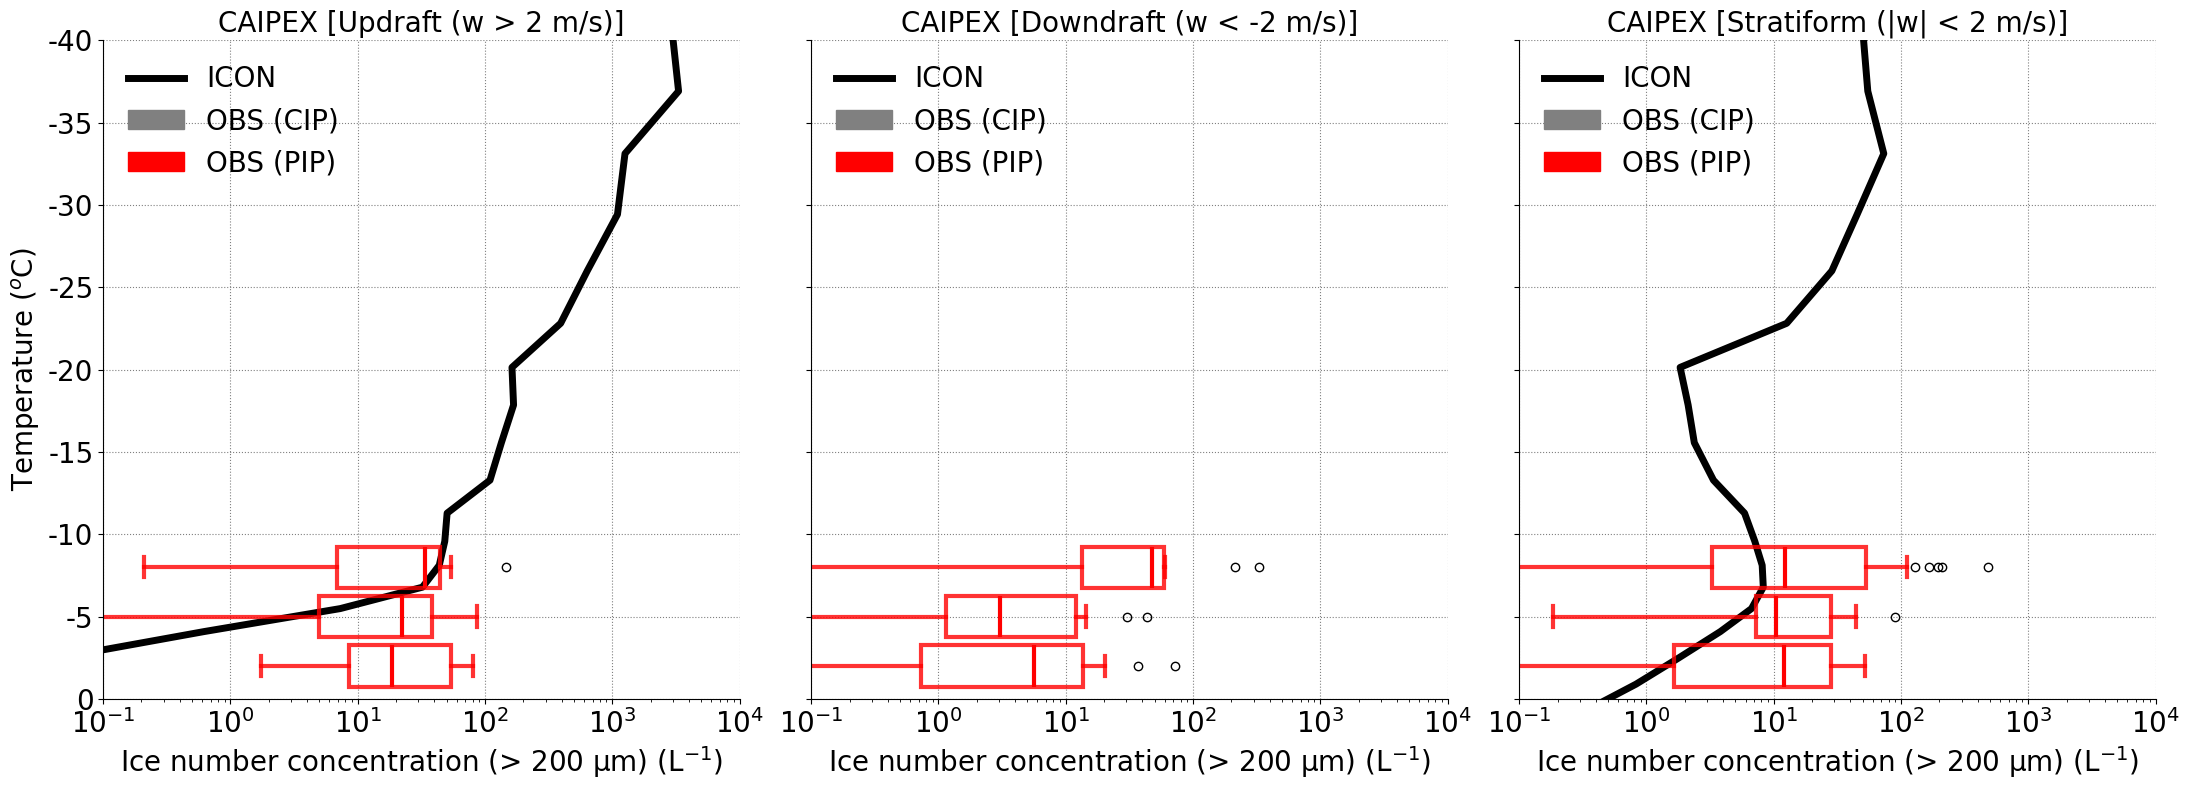

In [205]:

ds_pip_nc = xr.open_mfdataset('/work/bk1415/b382718/output/caipeex/observations/aircraft_Data_AR_SIP_case/PIP/09302019_000000_PIP.nc');

data_pip = pd.DataFrame()
data_pip['time'] = ds_pip_nc['utc_time']
data_pip['NT100'] = ds_pip_nc['NT100']
data_pip['NT200'] = ds_pip_nc['NT200']
data_pip['IWC100'] = ds_pip_nc['IWC100']
data_pip['IWC200'] = ds_pip_nc['IWC200']
data_pip['NT200_perl'] = 1.e-3*ds_pip_nc['NT200']

data_v2_pip_comb = pd.merge(ds_v2, data_pip, on='time', how='inner')

##=========== PIP TINC
data_v2_pip_comb['ni200um_pip_up_perl'] = np.where((data_v2_pip_comb.NT200_perl > 1.e-3) & (data_v2_pip_comb.vert_vel > 2.), 
                                        data_v2_pip_comb.NT200_perl, np.nan)
data_v2_pip_comb['ni200um_pip_dn_perl'] = np.where((data_v2_pip_comb.NT200_perl > 1.e-3) & (data_v2_pip_comb.vert_vel < -2.), 
                                        data_v2_pip_comb.NT200_perl, np.nan)
data_v2_pip_comb['ni200um_pip_st_perl'] = np.where((data_v2_pip_comb.NT200_perl > 1.e-3) & (np.abs(data_v2_pip_comb.vert_vel) < 2.), 
                                        data_v2_pip_comb.NT200_perl, np.nan)
##=========== PIP IWC
data_v2_pip_comb['iwc_pip_up_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (data_v2_pip_comb.vert_vel > 2.), 
                                        data_v2_pip_comb.IWC200, np.nan)
data_v2_pip_comb['iwc_pip_dn_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (data_v2_pip_comb.vert_vel < -2.), 
                                        data_v2_pip_comb.IWC200, np.nan)
data_v2_pip_comb['iwc_pip_st_gperm3'] = np.where((data_v2_pip_comb.IWC200 > 1.e-3) & (np.abs(data_v2_pip_comb.vert_vel) < 2.), 
                                        data_v2_pip_comb.IWC200, np.nan)

##=============== PIP
data_v2_pip_comb = pd.DataFrame(data_v2_pip_comb)

temp_pip_bin = np.arange(-20, 0, 3)
temp_pip_bin = np.sort(temp_pip_bin)

data_v2_pip_comb['temp_pip_bin'] = np.digitize(data_v2_pip_comb['tempc'], bins=temp_pip_bin, right=False)

bin_edges = np.concatenate([temp_pip_bin - 2, [temp_pip_bin[-1] + 2]])  
data_v2_pip_comb['temp_bin'] = bin_edges[data_v2_pip_comb['temp_pip_bin']]

# PIP-TINC
df_ni200_up_pip = data_v2_pip_comb[['ni200um_pip_up_perl', 'temp_bin']].dropna()
df_ni200_dn_pip = data_v2_pip_comb[['ni200um_pip_dn_perl', 'temp_bin']].dropna()
df_ni200_st_pip = data_v2_pip_comb[['ni200um_pip_st_perl', 'temp_bin']].dropna()

df_ni200_up_pip = df_ni200_up_pip.dropna(subset=['temp_bin'])
df_ni200_dn_pip = df_ni200_dn_pip.dropna(subset=['temp_bin'])
df_ni200_st_pip = df_ni200_st_pip.dropna(subset=['temp_bin'])

ni200_pip_up_by_bin = [df_ni200_up_pip[df_ni200_up_pip['temp_bin'] == temp]['ni200um_pip_up_perl'].values for temp in bin_edges]
ni200_pip_dn_by_bin = [df_ni200_dn_pip[df_ni200_dn_pip['temp_bin'] == temp]['ni200um_pip_dn_perl'].values for temp in bin_edges]
ni200_pip_st_by_bin = [df_ni200_st_pip[df_ni200_st_pip['temp_bin'] == temp]['ni200um_pip_st_perl'].values for temp in bin_edges]

# PIP-IWC
df_iwc_up_pip = data_v2_pip_comb[['iwc_pip_up_gperm3', 'temp_bin']].dropna()
df_iwc_dn_pip = data_v2_pip_comb[['iwc_pip_dn_gperm3', 'temp_bin']].dropna()
df_iwc_st_pip = data_v2_pip_comb[['iwc_pip_st_gperm3', 'temp_bin']].dropna()

df_iwc_up_pip = df_iwc_up_pip.dropna(subset=['temp_bin'])
df_iwc_dn_pip = df_iwc_dn_pip.dropna(subset=['temp_bin'])
df_iwc_st_pip = df_iwc_st_pip.dropna(subset=['temp_bin'])

iwc_pip_up_by_bin = [df_iwc_up_pip[df_iwc_up_pip['temp_bin'] == temp]['iwc_pip_up_gperm3'].values for temp in bin_edges]
iwc_pip_dn_by_bin = [df_iwc_dn_pip[df_iwc_dn_pip['temp_bin'] == temp]['iwc_pip_dn_gperm3'].values for temp in bin_edges]
iwc_pip_st_by_bin = [df_iwc_st_pip[df_iwc_st_pip['temp_bin'] == temp]['iwc_pip_st_gperm3'].values for temp in bin_edges]

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEX [Updraft (w > 2 m/s)]', 'CAIPEX [Downdraft (w < -2 m/s)]', 'CAIPEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 3;
width=2.5
alpha = 0.8
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    if i == 0:
        ax.plot(inc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(ni200_pip_up_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))
        
    elif i == 1:
        ax.plot(inc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(ni200_pip_dn_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))
    
    elif i == 2:
        ax.plot(inc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(ni200_pip_st_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-1, 1.e4)
    ax.set_xticklabels([1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4], fontsize=fontsize)
    ax.set_ylim(0, -40)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice number concentration (> 200 µm) (L$^{-1 }$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='grey', label='OBS (CIP)')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (PIP)')

    ax.legend(handles=handles + [obs_patch1,obs_patch2], frameon=False, loc='upper left', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

#plt.plot(1.e-3*data_v2_pip_comb.NT200, data_v2_pip_comb.tempc)
#plt.ylim(0, -20)

/tmp/ipykernel_3649621/3973170741.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_3649621/3973170741.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
/tmp/ipykernel_3649621/3973170741.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)


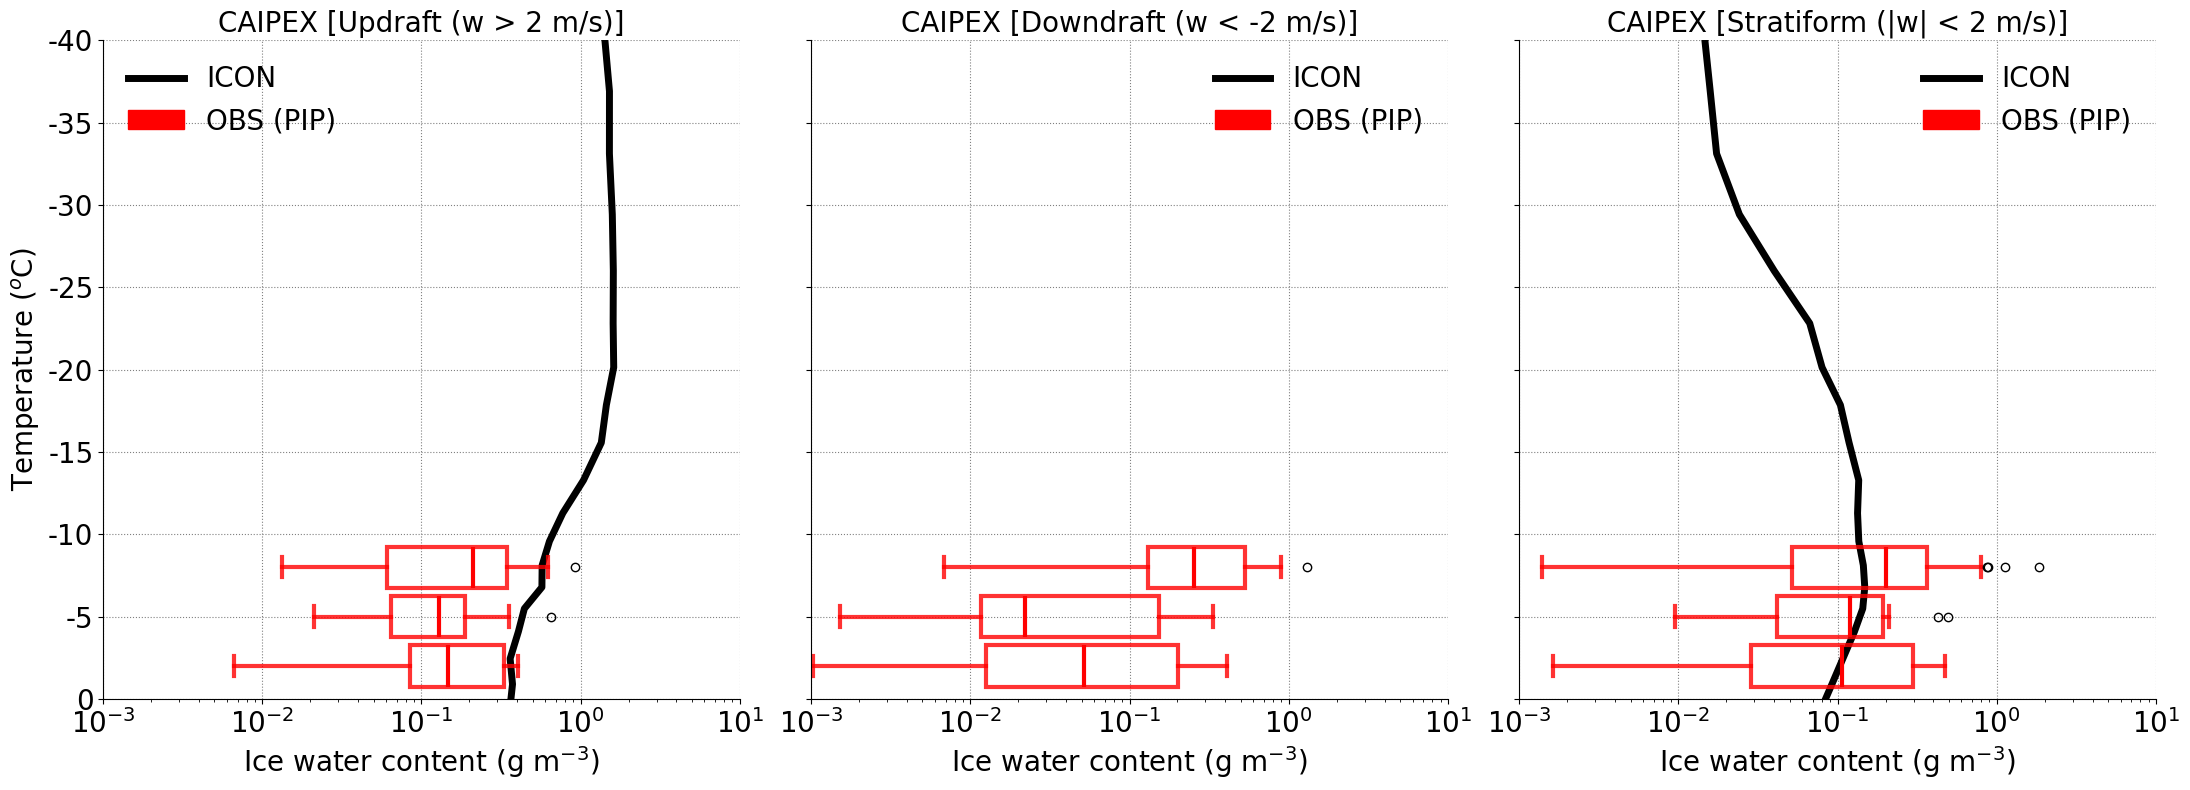

In [206]:

fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['CAIPEX [Updraft (w > 2 m/s)]', 'CAIPEX [Downdraft (w < -2 m/s)]', 'CAIPEX [Stratiform (|w| < 2 m/s)]']

fontsize = 20;
linewidth = 3;
width=2.5
alpha = 0.8
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    if i == 0:
        ax.plot(tiwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_pip_up_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))
        
    elif i == 1:
        ax.plot(tiwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_pip_dn_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))

    
    elif i == 2:
        ax.plot(tiwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_pip_st_by_bin[:-1], positions=temp_pip_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha))

    ax.set_xscale('log')
    ax.set_xlim(1.e-3, 1.e1)
    ax.set_xticklabels([1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(0, -40)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice water content (g m$^{-3 }$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch = mpatches.Patch(color='red', label='OBS (PIP)')

    ax.legend(handles=handles + [obs_patch], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40'], fontsize=fontsize)

plt.tight_layout()
plt.show()

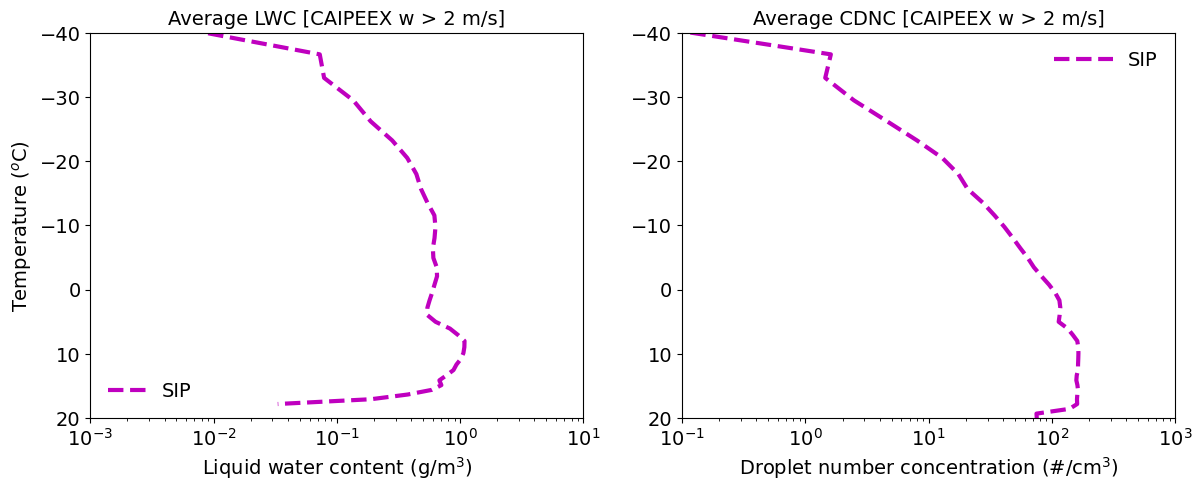

In [312]:


#filt_lwc_nosip = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > 2.), ds_nosip_new.lwc_gperm3, np.nan)
#filt_cdnc_nosip = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-3) & (ds_nosip_new.w_vel > 2.), ds_nosip_new.cdnc_percm3, np.nan)

filt_lwc_sip = xr.where((ds_sip_new.lwc_gperm3 > 1.e-6) & (ds_sip_new.w_vel > 2.), ds_sip_new.lwc_gperm3, np.nan)
filt_cdnc_sip = xr.where((ds_sip_new.cdnc_percm3 > 1.e-3) & (ds_sip_new.w_vel > 2.), ds_sip_new.cdnc_percm3, np.nan)


# Plotting
plt.figure(figsize=(14, 5))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.subplot(1,2,1)
#plt.plot(filt_lwc_nosip_2mom.mean(dim=('time','ncells')),ds_nosip.tempc.mean(dim=('time','ncells')), 
#         'k-', label=' No SIP', linewidth = lnwdth)
plt.plot(filt_lwc_sip.mean(dim=('time','ncells')),ds_sip.tempc.mean(dim=('time','ncells')), 
         'm--', label='SIP', linewidth = lnwdth)
plt.xscale('log')
plt.xlim(1.e-3, 1.e1)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e1,1.e0,1.e1], fontsize=fontsize)
plt.ylim(20, -40)
plt.yticks([20,10,0,-10,-20,-30,-40], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Liquid water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average LWC [CAIPEEX w > 2 m/s]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='lower left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)

plt.subplot(1,2,2)

#plt.plot(filt_cdnc_nosip_2mom.mean(dim=('time','ncells')), ds_nosip_steps.tempc.mean(dim=('time','ncells')), 
#         'k-', label='NO SIP', linewidth = lnwdth)
plt.plot(filt_cdnc_sip.mean(dim=('time','ncells')), ds_sip.tempc.mean(dim=('time','ncells')), 
         'm--', label='SIP', linewidth = lnwdth)

plt.xlim(1.e-1, 1.e3)
plt.xticks([1.e-1,1.e0,1.e1,1.e2,1.e3], fontsize=fontsize)
plt.ylim(20, -40)
plt.yticks([20,10,0,-10,-20,-30,-40], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Droplet number concentration (#/cm$^{3}$)', fontsize=fontsize)
plt.title('Average CDNC [CAIPEEX w > 2 m/s]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=3, labelspacing=0.05, fontsize=fontsize, loc='upper right')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)

plt.show()


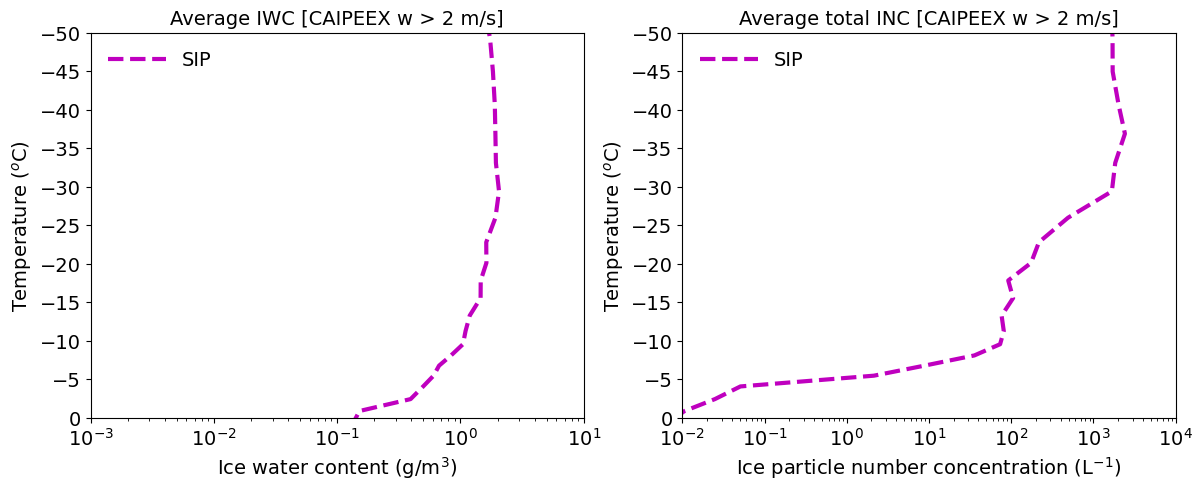

In [20]:


#filt_tiwc_nosip = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > 2.), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_inc_nosip = xr.where((ds_nosip_new.inc_perl > 1.e-3) & (ds_nosip_new.w_vel > 2.), ds_nosip_new.inc_perl, np.nan)

filt_tiwc_sip = xr.where((ds_sip_new.tiwc_gperm3 > 1.e-6) & (ds_sip_new.w_vel > 2.), ds_sip_new.tiwc_gperm3, np.nan)
filt_inc_sip = xr.where((ds_sip_new.inc_perl > 1.e-3) & (ds_sip_new.w_vel > 2.), ds_sip_new.inc_perl, np.nan)

# Plotting
plt.figure(figsize=(14, 5))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=14
plt.subplot(1,2,1)
#plt.plot(filt_tiwc_2mom.mean(dim=('time','ncells')),ds_nosip_steps.tempc.mean(dim=('time','ncells')), 
#         'k-', label='NO SIP', linewidth = lnwdth)
plt.plot(filt_tiwc_sip.mean(dim=('time','ncells')),ds_sip_new.tempc.mean(dim=('time','ncells')), 
         'm--', label='SIP', linewidth = lnwdth)

# Setting plot limits and labels
plt.xlim(1.e-3, 1.e1)
plt.xticks([1.e-3,1.e-2,1.e-1,1.e1,1.e0,1.e1], fontsize=fontsize)
plt.ylim(0, -50)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Ice water content (g/m$^{3}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average IWC [CAIPEEX w > 2 m/s]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)

plt.subplot(1,2,2)
#plt.plot(filt_inc_2mom.mean(dim=('time','ncells')),ds_nosip_steps.tempc.mean(dim=('time','ncells')), 
#         'k-', label='NO SIP', linewidth = lnwdth)
plt.plot(filt_inc_sip.mean(dim=('time','ncells')),ds_sip_new.tempc.mean(dim=('time','ncells')), 
         'm--', label='SIP', linewidth = lnwdth)

# Setting plot limits and labels
plt.xlim(1.e-2, 1.e4)
plt.xticks([1.e-2,1.e0,1.e2,1.e4], fontsize=fontsize)
plt.ylim(0, -50)
plt.yticks([0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Ice particle number concentration (L$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('Average total INC [CAIPEEX w > 2 m/s]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=3, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))

# Show plot
plt.grid(False)
plt.show()

In [25]:

#######
min_tempc_sip = ds_sip.tempc.min().values
max_tempc_sip = ds_sip.tempc.max().values

min_wvel_sip = ds_sip.w_vel.min().values
max_wvel_sip = ds_sip.w_vel.max().values

num_temp_bin = 20; num_w_bin = 20;

temp_bin = np.linspace(min_tempc_sip, max_tempc_sip, num_temp_bin+1)
wvel_bin = np.linspace(min_wvel_sip, max_wvel_sip, num_w_bin+1)
#######

#######
tempc_sip_flat = ds_sip.tempc.values.flatten()
wvel_sip_flat = ds_sip.w_vel.values.flatten()

qc_sip_flat = ds_sip.qc.values.flatten()
qi_sip_flat = ds_sip.qi.values.flatten()
qs_sip_flat = ds_sip.qs.values.flatten()
qg_sip_flat = ds_sip.qg.values.flatten()
qh_sip_flat = ds_sip.qh.values.flatten()
tqi_sip_flat = ds_sip.tqi.values.flatten()
#######

hist_sip, temp_edges_sip, wvel_edges_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin))

#######
qc_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qc_sip_flat)[0]
qi_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qi_sip_flat)[0]
qs_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qs_sip_flat)[0]
qg_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qg_sip_flat)[0]
qh_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qh_sip_flat)[0]
tqi_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = tqi_sip_flat)[0]
#######

#######
avg_qc_temp_w_sip = qc_sum_sip/hist_sip
avg_qc_temp_w_sip[avg_qc_temp_w_sip < 1.e-9] = np.nan

avg_qi_temp_w_sip = qi_sum_sip/hist_sip
avg_qi_temp_w_sip[avg_qi_temp_w_sip < 1.e-9] = np.nan

avg_qs_temp_w_sip = qs_sum_sip/hist_sip
avg_qs_temp_w_sip[avg_qs_temp_w_sip < 1.e-9] = np.nan

avg_qg_temp_w_sip = qg_sum_sip/hist_sip
avg_qg_temp_w_sip[avg_qg_temp_w_sip < 1.e-9] = np.nan

avg_qh_temp_w_sip = qh_sum_sip/hist_sip
avg_qh_temp_w_sip[avg_qh_temp_w_sip < 1.e-9] = np.nan

avg_tqi_temp_w_sip = tqi_sum_sip/hist_sip
avg_tqi_temp_w_sip[avg_tqi_temp_w_sip < 1.e-9] = np.nan
#######


/tmp/ipykernel_1917976/3900975349.py:8: RuntimeWarning: invalid value encountered in divide
  avg_qc_temp_w_sip = qc_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:11: RuntimeWarning: invalid value encountered in divide
  avg_qi_temp_w_sip = qi_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:14: RuntimeWarning: invalid value encountered in divide
  avg_qs_temp_w_sip = qs_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:17: RuntimeWarning: invalid value encountered in divide
  avg_qg_temp_w_sip = qg_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:20: RuntimeWarning: invalid value encountered in divide
  avg_qh_temp_w_sip = qh_sum_sip/hist_sip
/tmp/ipykernel_1917976/3900975349.py:23: RuntimeWarning: invalid value encountered in divide
  avg_tqi_temp_w_sip = tqi_sum_sip/hist_sip


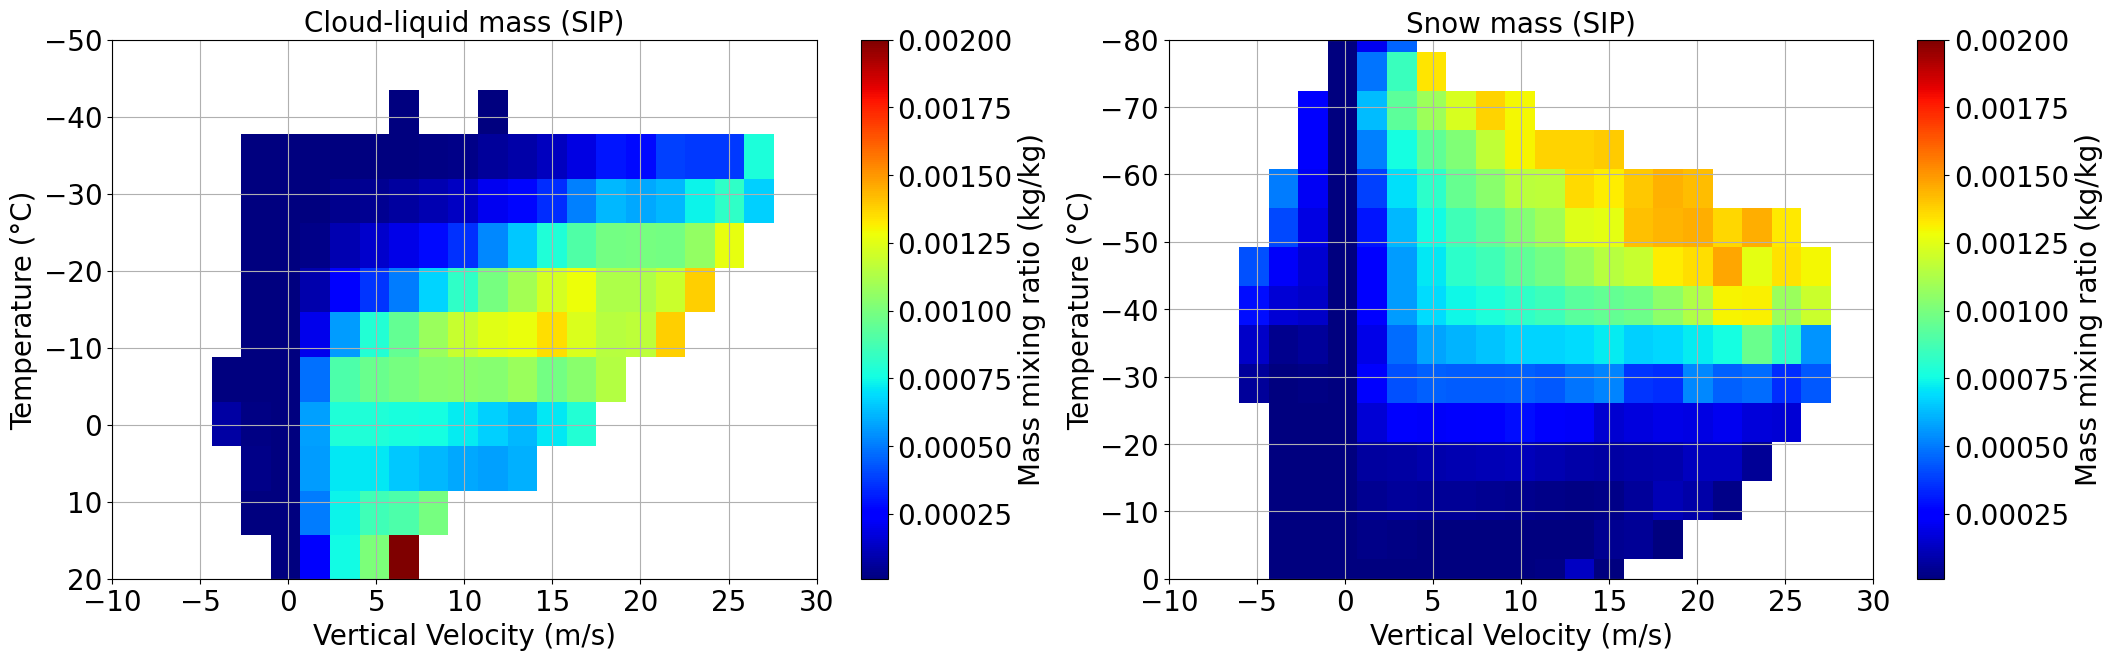

In [37]:

fontsize = 20;

plt.figure(figsize=(25, 7))
plt.subplot(1,2,1)
contour=plt.imshow(avg_qc_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -50)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Cloud-liquid mass (SIP)', fontsize=fontsize)

plt.subplot(1,2,2)
contour=plt.imshow(avg_qi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Snow mass (SIP)', fontsize=fontsize)
plt.show()

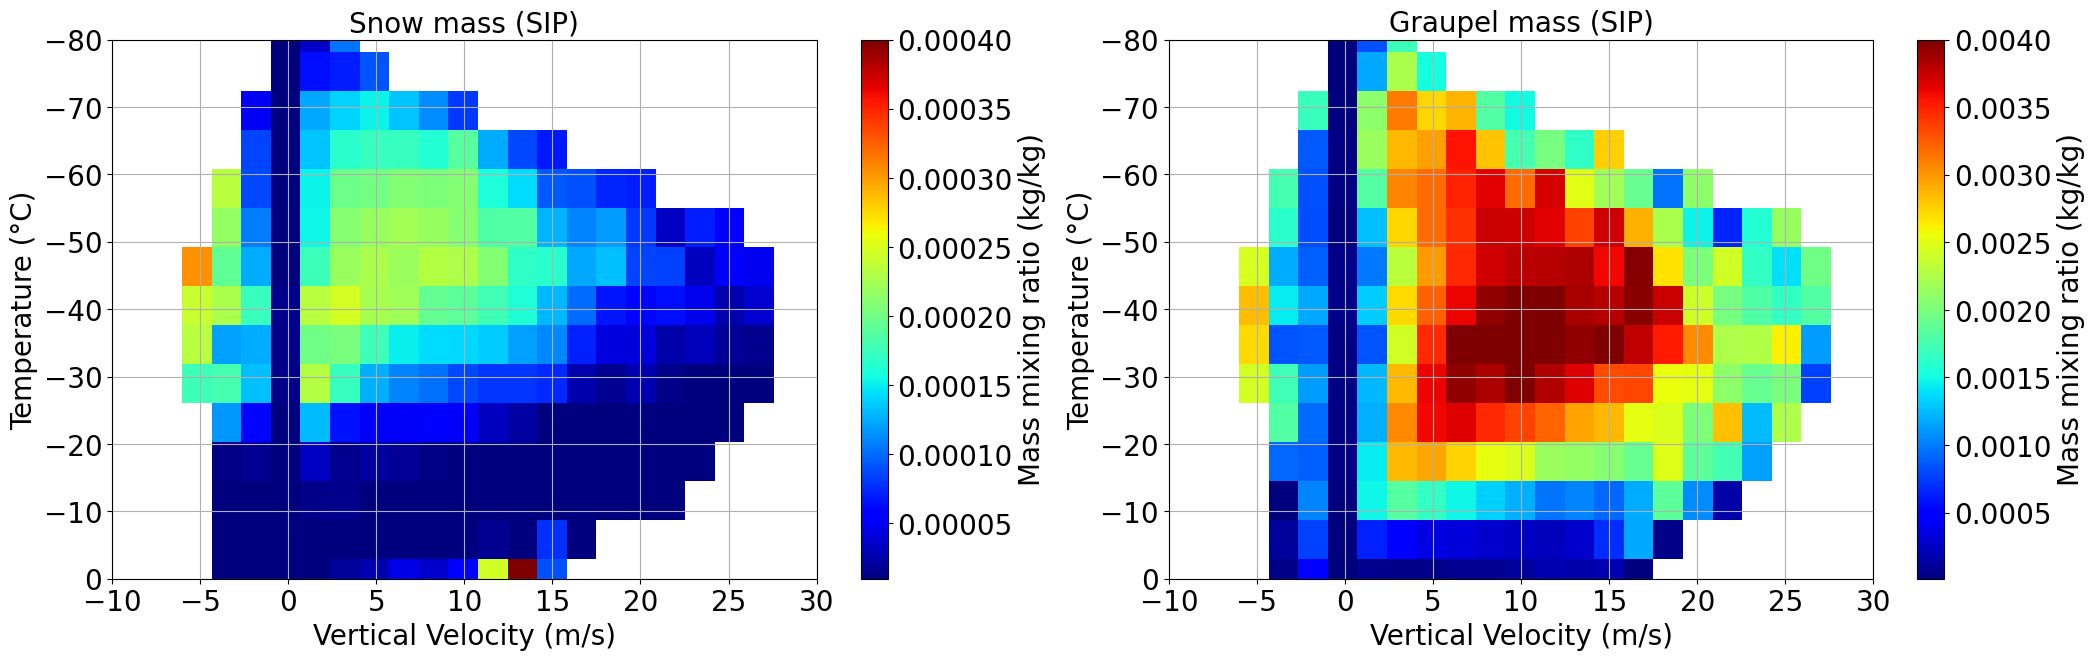

In [36]:

fontsize = 20;

plt.figure(figsize=(25, 7))
plt.subplot(1,2,1)
contour=plt.imshow(avg_qs_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=4.e-4, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Snow mass (SIP)', fontsize=fontsize)

plt.subplot(1,2,2)
contour=plt.imshow(avg_qg_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=4.e-3, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Graupel mass (SIP)', fontsize=fontsize)

plt.show()

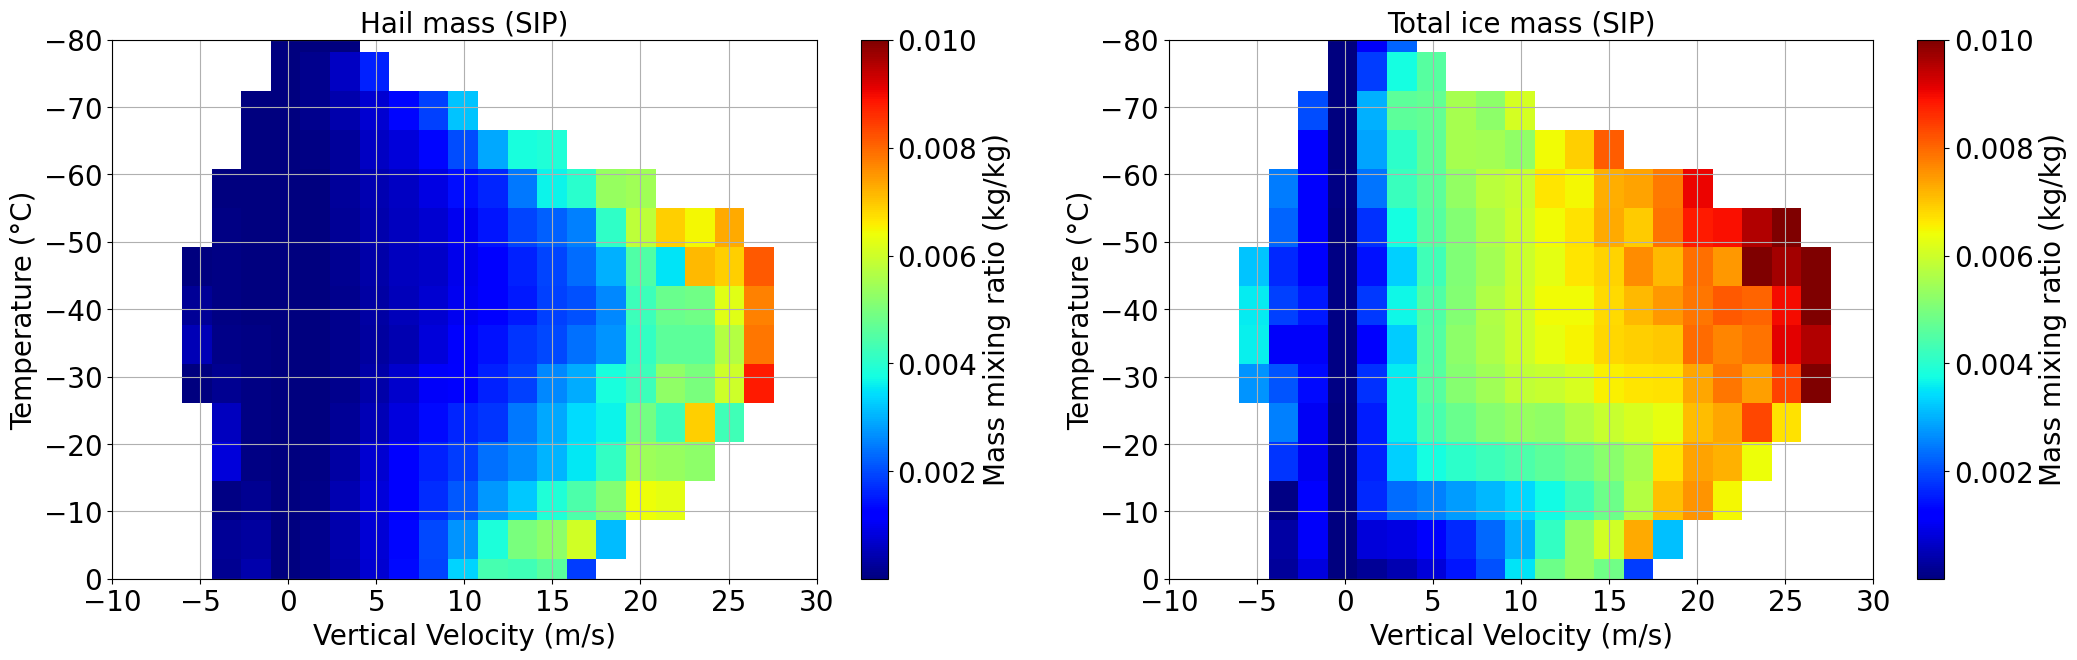

In [43]:

fontsize = 20;

plt.figure(figsize=(25, 7))
plt.subplot(1,2,1)
contour=plt.imshow(avg_qh_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=1.e-2, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Hail mass (SIP)', fontsize=fontsize)

plt.subplot(1,2,2)
contour=plt.imshow(avg_tqi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=1.e-2, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Total ice mass (SIP)', fontsize=fontsize)

plt.show()

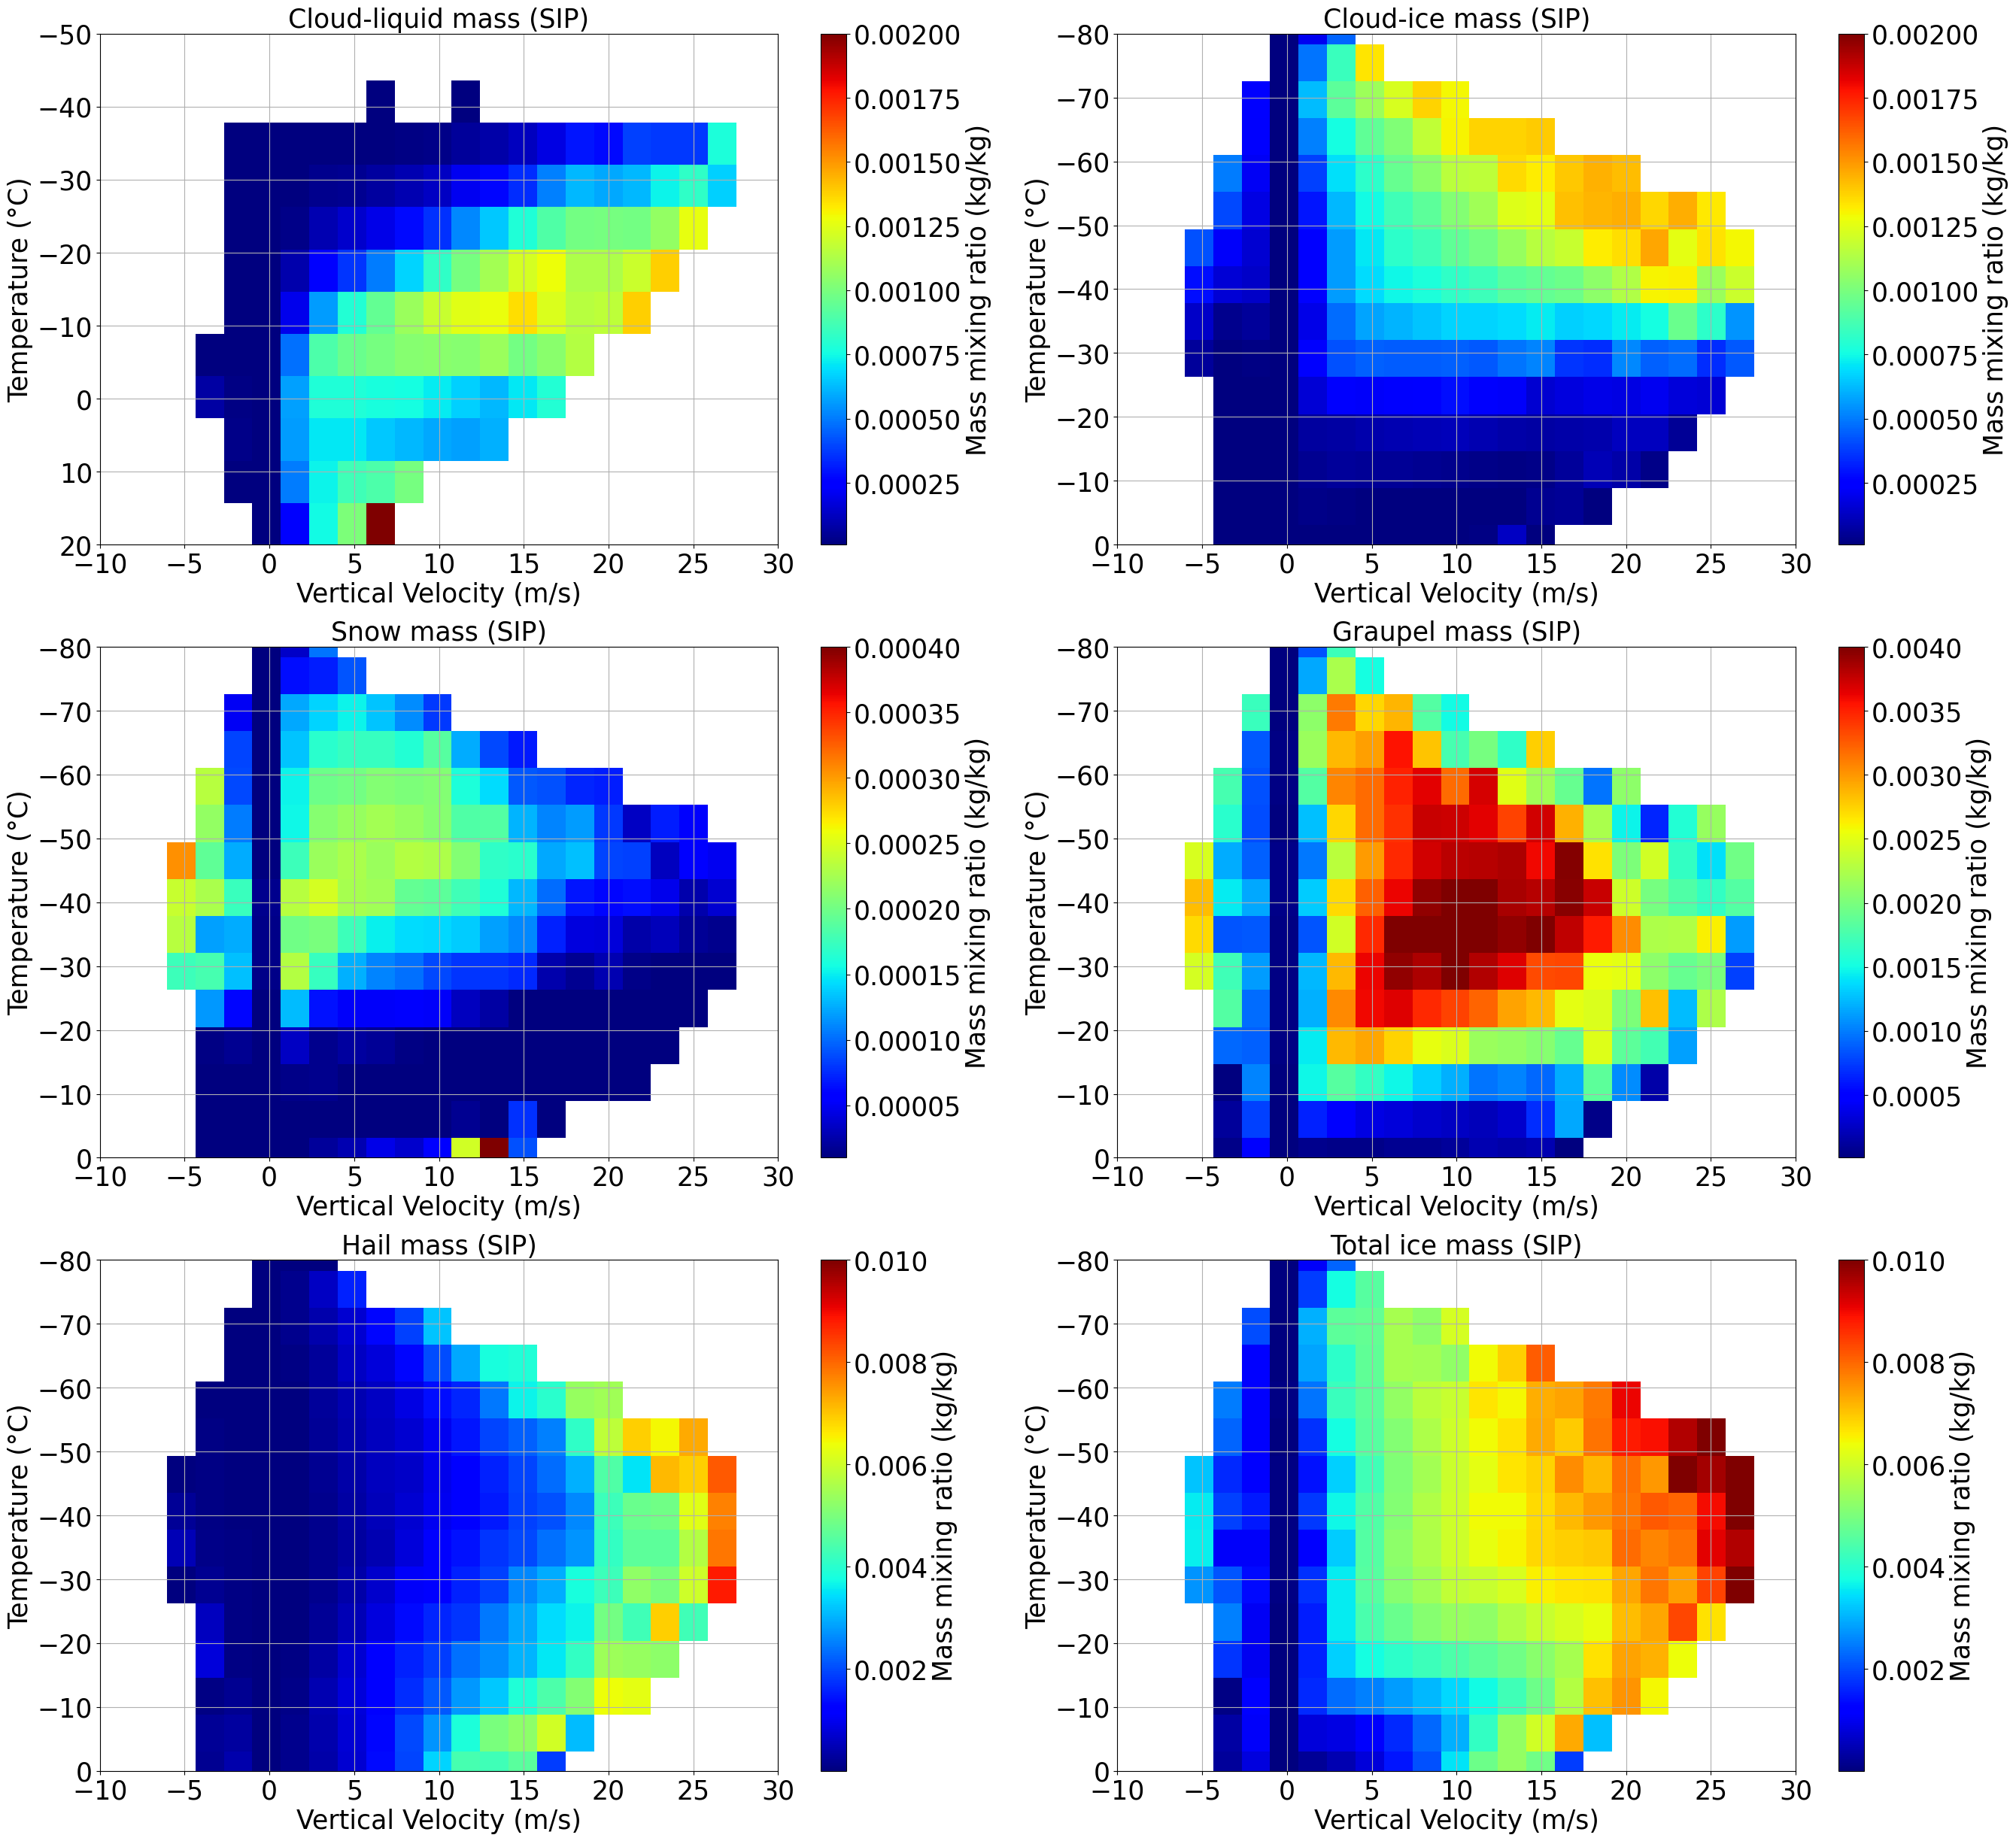

In [64]:


fontsize = 25;

plt.figure(figsize=(32, 30))
plt.subplot(3,2,1)
contour=plt.imshow(avg_qc_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -50)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Cloud-liquid mass (SIP)', fontsize=fontsize)

plt.subplot(3,2,2)
contour=plt.imshow(avg_qi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=2.e-3, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Cloud-ice mass (SIP)', fontsize=fontsize)
#plt.show()


#fontsize = 20;

#plt.figure(figsize=(25, 7))
plt.subplot(3,2,3)
contour=plt.imshow(avg_qs_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=4.e-4, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Snow mass (SIP)', fontsize=fontsize)

plt.subplot(3,2,4)
contour=plt.imshow(avg_qg_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=4.e-3, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Graupel mass (SIP)', fontsize=fontsize)

#plt.show()


#fontsize = 20;

#plt.figure(figsize=(25, 7))
plt.subplot(3,2,5)
contour=plt.imshow(avg_qh_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=1.e-2, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Hail mass (SIP)', fontsize=fontsize)

plt.subplot(3,2,6)
contour=plt.imshow(avg_tqi_temp_w_sip, extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=1.e-5, vmax=1.e-2, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(0, -80)
plt.yticks([0, -10, -20, -30, -40, -50, -60, -70, -80], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Average mass (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Mass mixing ratio (kg/kg)', size=fontsize)

plt.title('Total ice mass (SIP)', fontsize=fontsize)

plt.show()


In [55]:
ds_sip

<xarray.Dataset>
Dimensions:        (time: 41, ncells: 68960, vertices: 3, height: 65, bnds: 2,
                    height_2: 66, plev: 1, plev_2: 1, plev_3: 1)
Coordinates:
  * time           (time) datetime64[ns] 2019-09-30 ... 2019-09-30T20:00:00
    clon           (ncells) float64 dask.array<chunksize=(68960,), meta=np.ndarray>
    clat           (ncells) float64 dask.array<chunksize=(68960,), meta=np.ndarray>
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 62.0 63.0 64.0 65.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 63.0 64.0 65.0 66.0
  * plev           (plev) float64 800.0
  * plev_2         (plev_2) float64 400.0
  * plev_3         (plev_3) float64 0.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/78)
    clon_bnds      (time, ncells, vertices) float64 dask.array<chunksize=(1, 68960, 3), meta=np.ndarray>
    clat_bnds      (time, ncells, vertices) float64 dask.array<chunksize=(1, 68960, 3), meta=np.ndarray>
    height_bnds    (time, height, bnds) float64 dask.array<chunksize=(1, 65, 2), meta=np.ndarray>
    plev_bnds      (time, plev, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    plev_2_bnds    (time, plev_2, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    plev_3_bnds    (time, plev_3, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    ...             ...
    lwc_gperm3     (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    ciwc_gperm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    tqi            (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    tiwc_gperm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    cdnc_percm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    inc_perl       (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 2.4.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  99
    uuidOfHGrid:          3eb4f381-adbd-e79a-b32f-6e1ff3ba2860
    uuidOfVGrid:          acbf7b33-d4a3-b631-6ecd-012f775e2bc0
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               version: 2024.10; revision: 885c4646a69d44aa9e9fdf4...
    history:              /home/b/b382718/tdf_sip_lfr/icon-oct2024/bin/icon a...
    references:           see MPIM/DWD publications
    comment:              Deepak Waman (b382718) on l40278 (Linux 4.18.0-513....

In [129]:

#######
min_tempc_sip = ds_sip.tempc.min().values
max_tempc_sip = ds_sip.tempc.max().values

min_wvel_sip = ds_sip.w_vel.min().values
max_wvel_sip = ds_sip.w_vel.max().values

num_temp_bin = 20; num_w_bin = 20;

temp_bin = np.linspace(min_tempc_sip, max_tempc_sip, num_temp_bin+1)
wvel_bin = np.linspace(min_wvel_sip, max_wvel_sip, num_w_bin+1)
#######

#######
tempc_sip_flat = ds_sip.tempc.values.flatten()
wvel_sip_flat = ds_sip.w_vel.values.flatten()

qc_rim_i_sip_flat = ds_sip.d_qc_rime_i.values.flatten()
qr_rim_i_sip_flat = ds_sip.d_qr_rime_i.values.flatten()
qc_rim_s_sip_flat = ds_sip.d_qc_rime_s.values.flatten()
qr_rim_s_sip_flat = ds_sip.d_qr_rime_s.values.flatten()

qi_dep_sip_flat = ds_sip.d_qi_dep.values.flatten()
qs_dep_sip_flat = ds_sip.d_qs_dep.values.flatten()

qi_hom_sip_flat = ds_sip.d_qi_hom.values.flatten()
qi_homhet_sip_flat = ds_sip.d_qi_homhet.values.flatten()

qc_nuc_sip_flat = ds_sip.d_qc_nuc.values.flatten()
#######

hist_sip, temp_edges_sip, wvel_edges_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin))

#######
qc_rim_i_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qc_rim_i_sip_flat)[0]
qr_rim_i_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qr_rim_i_sip_flat)[0]

qc_rim_s_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qc_rim_s_sip_flat)[0]
qr_rim_s_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qr_rim_s_sip_flat)[0]

qi_dep_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qi_dep_sip_flat)[0]
qs_dep_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qs_dep_sip_flat)[0]

qi_hom_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qi_hom_sip_flat)[0]
qi_homhet_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qi_homhet_sip_flat)[0]

qc_nuc_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qc_nuc_sip_flat)[0]
#######

#######
avg_qc_rim_i_temp_w_sip = qc_rim_i_sum_sip/hist_sip
avg_qc_rim_i_temp_w_sip[avg_qc_rim_i_temp_w_sip < 1.e-14] = np.nan

avg_qr_rim_i_temp_w_sip = qr_rim_i_sum_sip/hist_sip
avg_qr_rim_i_temp_w_sip[avg_qr_rim_i_temp_w_sip < 1.e-14] = np.nan

avg_qc_rim_s_temp_w_sip = qc_rim_s_sum_sip/hist_sip
avg_qc_rim_s_temp_w_sip[avg_qc_rim_s_temp_w_sip < 1.e-14] = np.nan

avg_qr_rim_s_temp_w_sip = qr_rim_s_sum_sip/hist_sip
avg_qr_rim_s_temp_w_sip[avg_qr_rim_s_temp_w_sip < 1.e-14] = np.nan

avg_qi_dep_temp_w_sip = qi_dep_sum_sip/hist_sip
avg_qi_dep_temp_w_sip[avg_qi_dep_temp_w_sip < 1.e-14] = np.nan

avg_qs_dep_temp_w_sip = qs_dep_sum_sip/hist_sip
avg_qs_dep_temp_w_sip[avg_qs_dep_temp_w_sip < 1.e-14] = np.nan

avg_qi_hom_temp_w_sip = qi_hom_sum_sip/hist_sip
avg_qi_hom_temp_w_sip[avg_qi_hom_temp_w_sip < 1.e-14] = np.nan

avg_qi_homhet_temp_w_sip = qi_homhet_sum_sip/hist_sip
avg_qi_homhet_temp_w_sip[avg_qi_homhet_temp_w_sip < 1.e-14] = np.nan

avg_qc_nuc_temp_w_sip = qc_nuc_sum_sip/hist_sip
avg_qc_nuc_temp_w_sip[avg_qc_nuc_temp_w_sip < 1.e-14] = np.nan


#######


/tmp/ipykernel_1917976/2895634958.py:51: RuntimeWarning: invalid value encountered in divide
  avg_qc_rim_i_temp_w_sip = qc_rim_i_sum_sip/hist_sip
/tmp/ipykernel_1917976/2895634958.py:54: RuntimeWarning: invalid value encountered in divide
  avg_qr_rim_i_temp_w_sip = qr_rim_i_sum_sip/hist_sip
/tmp/ipykernel_1917976/2895634958.py:57: RuntimeWarning: invalid value encountered in divide
  avg_qc_rim_s_temp_w_sip = qc_rim_s_sum_sip/hist_sip
/tmp/ipykernel_1917976/2895634958.py:60: RuntimeWarning: invalid value encountered in divide
  avg_qr_rim_s_temp_w_sip = qr_rim_s_sum_sip/hist_sip
/tmp/ipykernel_1917976/2895634958.py:63: RuntimeWarning: invalid value encountered in divide
  avg_qi_dep_temp_w_sip = qi_dep_sum_sip/hist_sip
/tmp/ipykernel_1917976/2895634958.py:66: RuntimeWarning: invalid value encountered in divide
  avg_qs_dep_temp_w_sip = qs_dep_sum_sip/hist_sip
/tmp/ipykernel_1917976/2895634958.py:69: RuntimeWarning: invalid value encountered in divide
  avg_qi_hom_temp_w_sip = qi_hom_

In [56]:

#######
min_tempc_sip = ds_sip.tempc.min().values
max_tempc_sip = ds_sip.tempc.max().values

min_wvel_sip = ds_sip.w_vel.min().values
max_wvel_sip = ds_sip.w_vel.max().values

num_temp_bin = 20; num_w_bin = 20;

temp_bin = np.linspace(min_tempc_sip, max_tempc_sip, num_temp_bin+1)
wvel_bin = np.linspace(min_wvel_sip, max_wvel_sip, num_w_bin+1)
#######

#######
tempc_sip_flat = ds_sip.tempc.values.flatten()
wvel_sip_flat = ds_sip.w_vel.values.flatten()

qr_ac_sip_flat = ds_sip.d_qr_ac.values.flatten()
qr_acc_sip_flat = ds_sip.d_qr_acc.values.flatten()
qr_evap_sip_flat = ds_sip.d_qr_evap.values.flatten()
qr_rf_sip_flat = ds_sip.d_qr_rf.values.flatten()
qh_rf_sip_flat = ds_sip.d_qh_rf.values.flatten()
qsqh_evap_sip_flat = ds_sip.d_qsgh_evap.values.flatten()
#######

hist_sip, temp_edges_sip, wvel_edges_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin))

#######
qr_ac_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qr_ac_sip_flat)[0]
qr_acc_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qr_acc_sip_flat)[0]
qr_evap_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qr_evap_sip_flat)[0]
qr_rf_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qr_rf_sip_flat)[0]
qh_rf_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qh_rf_sip_flat)[0]
qsqh_evap_sum_sip = np.histogram2d(tempc_sip_flat, wvel_sip_flat, bins=(temp_bin, wvel_bin), weights = qsqh_evap_sip_flat)[0]
#######

#######
avg_qr_ac_temp_w_sip = qr_ac_sum_sip/hist_sip
avg_qr_ac_temp_w_sip[avg_qr_ac_temp_w_sip < 1.e-14] = np.nan

avg_qr_acc_temp_w_sip = qr_acc_sum_sip/hist_sip
avg_qr_acc_temp_w_sip[avg_qr_acc_temp_w_sip < 1.e-14] = np.nan

avg_qr_evap_temp_w_sip = qr_evap_sum_sip/hist_sip
avg_qr_evap_temp_w_sip[avg_qr_evap_temp_w_sip < 1.e-14] = np.nan

avg_qr_rf_temp_w_sip = qr_rf_sum_sip/hist_sip
avg_qr_rf_temp_w_sip[avg_qr_rf_temp_w_sip < 1.e-14] = np.nan

avg_qh_rf_temp_w_sip = qh_rf_sum_sip/hist_sip
avg_qh_rf_temp_w_sip[avg_qh_rf_temp_w_sip < 1.e-14] = np.nan

avg_qsqh_evap_temp_w_sip = qsqh_evap_sum_sip/hist_sip
avg_qsqh_evap_temp_w_sip[avg_qsqh_evap_temp_w_sip < 1.e-14] = np.nan

#######


/tmp/ipykernel_1917976/3073495586.py:38: RuntimeWarning: invalid value encountered in divide
  avg_qr_ac_temp_w_sip = qr_ac_sum_sip/hist_sip
/tmp/ipykernel_1917976/3073495586.py:41: RuntimeWarning: invalid value encountered in divide
  avg_qr_acc_temp_w_sip = qr_acc_sum_sip/hist_sip
/tmp/ipykernel_1917976/3073495586.py:44: RuntimeWarning: invalid value encountered in divide
  avg_qr_evap_temp_w_sip = qr_evap_sum_sip/hist_sip
/tmp/ipykernel_1917976/3073495586.py:47: RuntimeWarning: invalid value encountered in divide
  avg_qr_rf_temp_w_sip = qr_rf_sum_sip/hist_sip
/tmp/ipykernel_1917976/3073495586.py:50: RuntimeWarning: invalid value encountered in divide
  avg_qh_rf_temp_w_sip = qh_rf_sum_sip/hist_sip
/tmp/ipykernel_1917976/3073495586.py:53: RuntimeWarning: invalid value encountered in divide
  avg_qsqh_evap_temp_w_sip = qsqh_evap_sum_sip/hist_sip


In [60]:
ds_sip

<xarray.Dataset>
Dimensions:        (time: 41, ncells: 68960, vertices: 3, height: 65, bnds: 2,
                    height_2: 66, plev: 1, plev_2: 1, plev_3: 1)
Coordinates:
  * time           (time) datetime64[ns] 2019-09-30 ... 2019-09-30T20:00:00
    clon           (ncells) float64 dask.array<chunksize=(68960,), meta=np.ndarray>
    clat           (ncells) float64 dask.array<chunksize=(68960,), meta=np.ndarray>
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 62.0 63.0 64.0 65.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 63.0 64.0 65.0 66.0
  * plev           (plev) float64 800.0
  * plev_2         (plev_2) float64 400.0
  * plev_3         (plev_3) float64 0.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/78)
    clon_bnds      (time, ncells, vertices) float64 dask.array<chunksize=(1, 68960, 3), meta=np.ndarray>
    clat_bnds      (time, ncells, vertices) float64 dask.array<chunksize=(1, 68960, 3), meta=np.ndarray>
    height_bnds    (time, height, bnds) float64 dask.array<chunksize=(1, 65, 2), meta=np.ndarray>
    plev_bnds      (time, plev, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    plev_2_bnds    (time, plev_2, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    plev_3_bnds    (time, plev_3, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    ...             ...
    lwc_gperm3     (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    ciwc_gperm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    tqi            (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    tiwc_gperm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    cdnc_percm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    inc_perl       (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 2.4.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  99
    uuidOfHGrid:          3eb4f381-adbd-e79a-b32f-6e1ff3ba2860
    uuidOfVGrid:          acbf7b33-d4a3-b631-6ecd-012f775e2bc0
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               version: 2024.10; revision: 885c4646a69d44aa9e9fdf4...
    history:              /home/b/b382718/tdf_sip_lfr/icon-oct2024/bin/icon a...
    references:           see MPIM/DWD publications
    comment:              Deepak Waman (b382718) on l40278 (Linux 4.18.0-513....

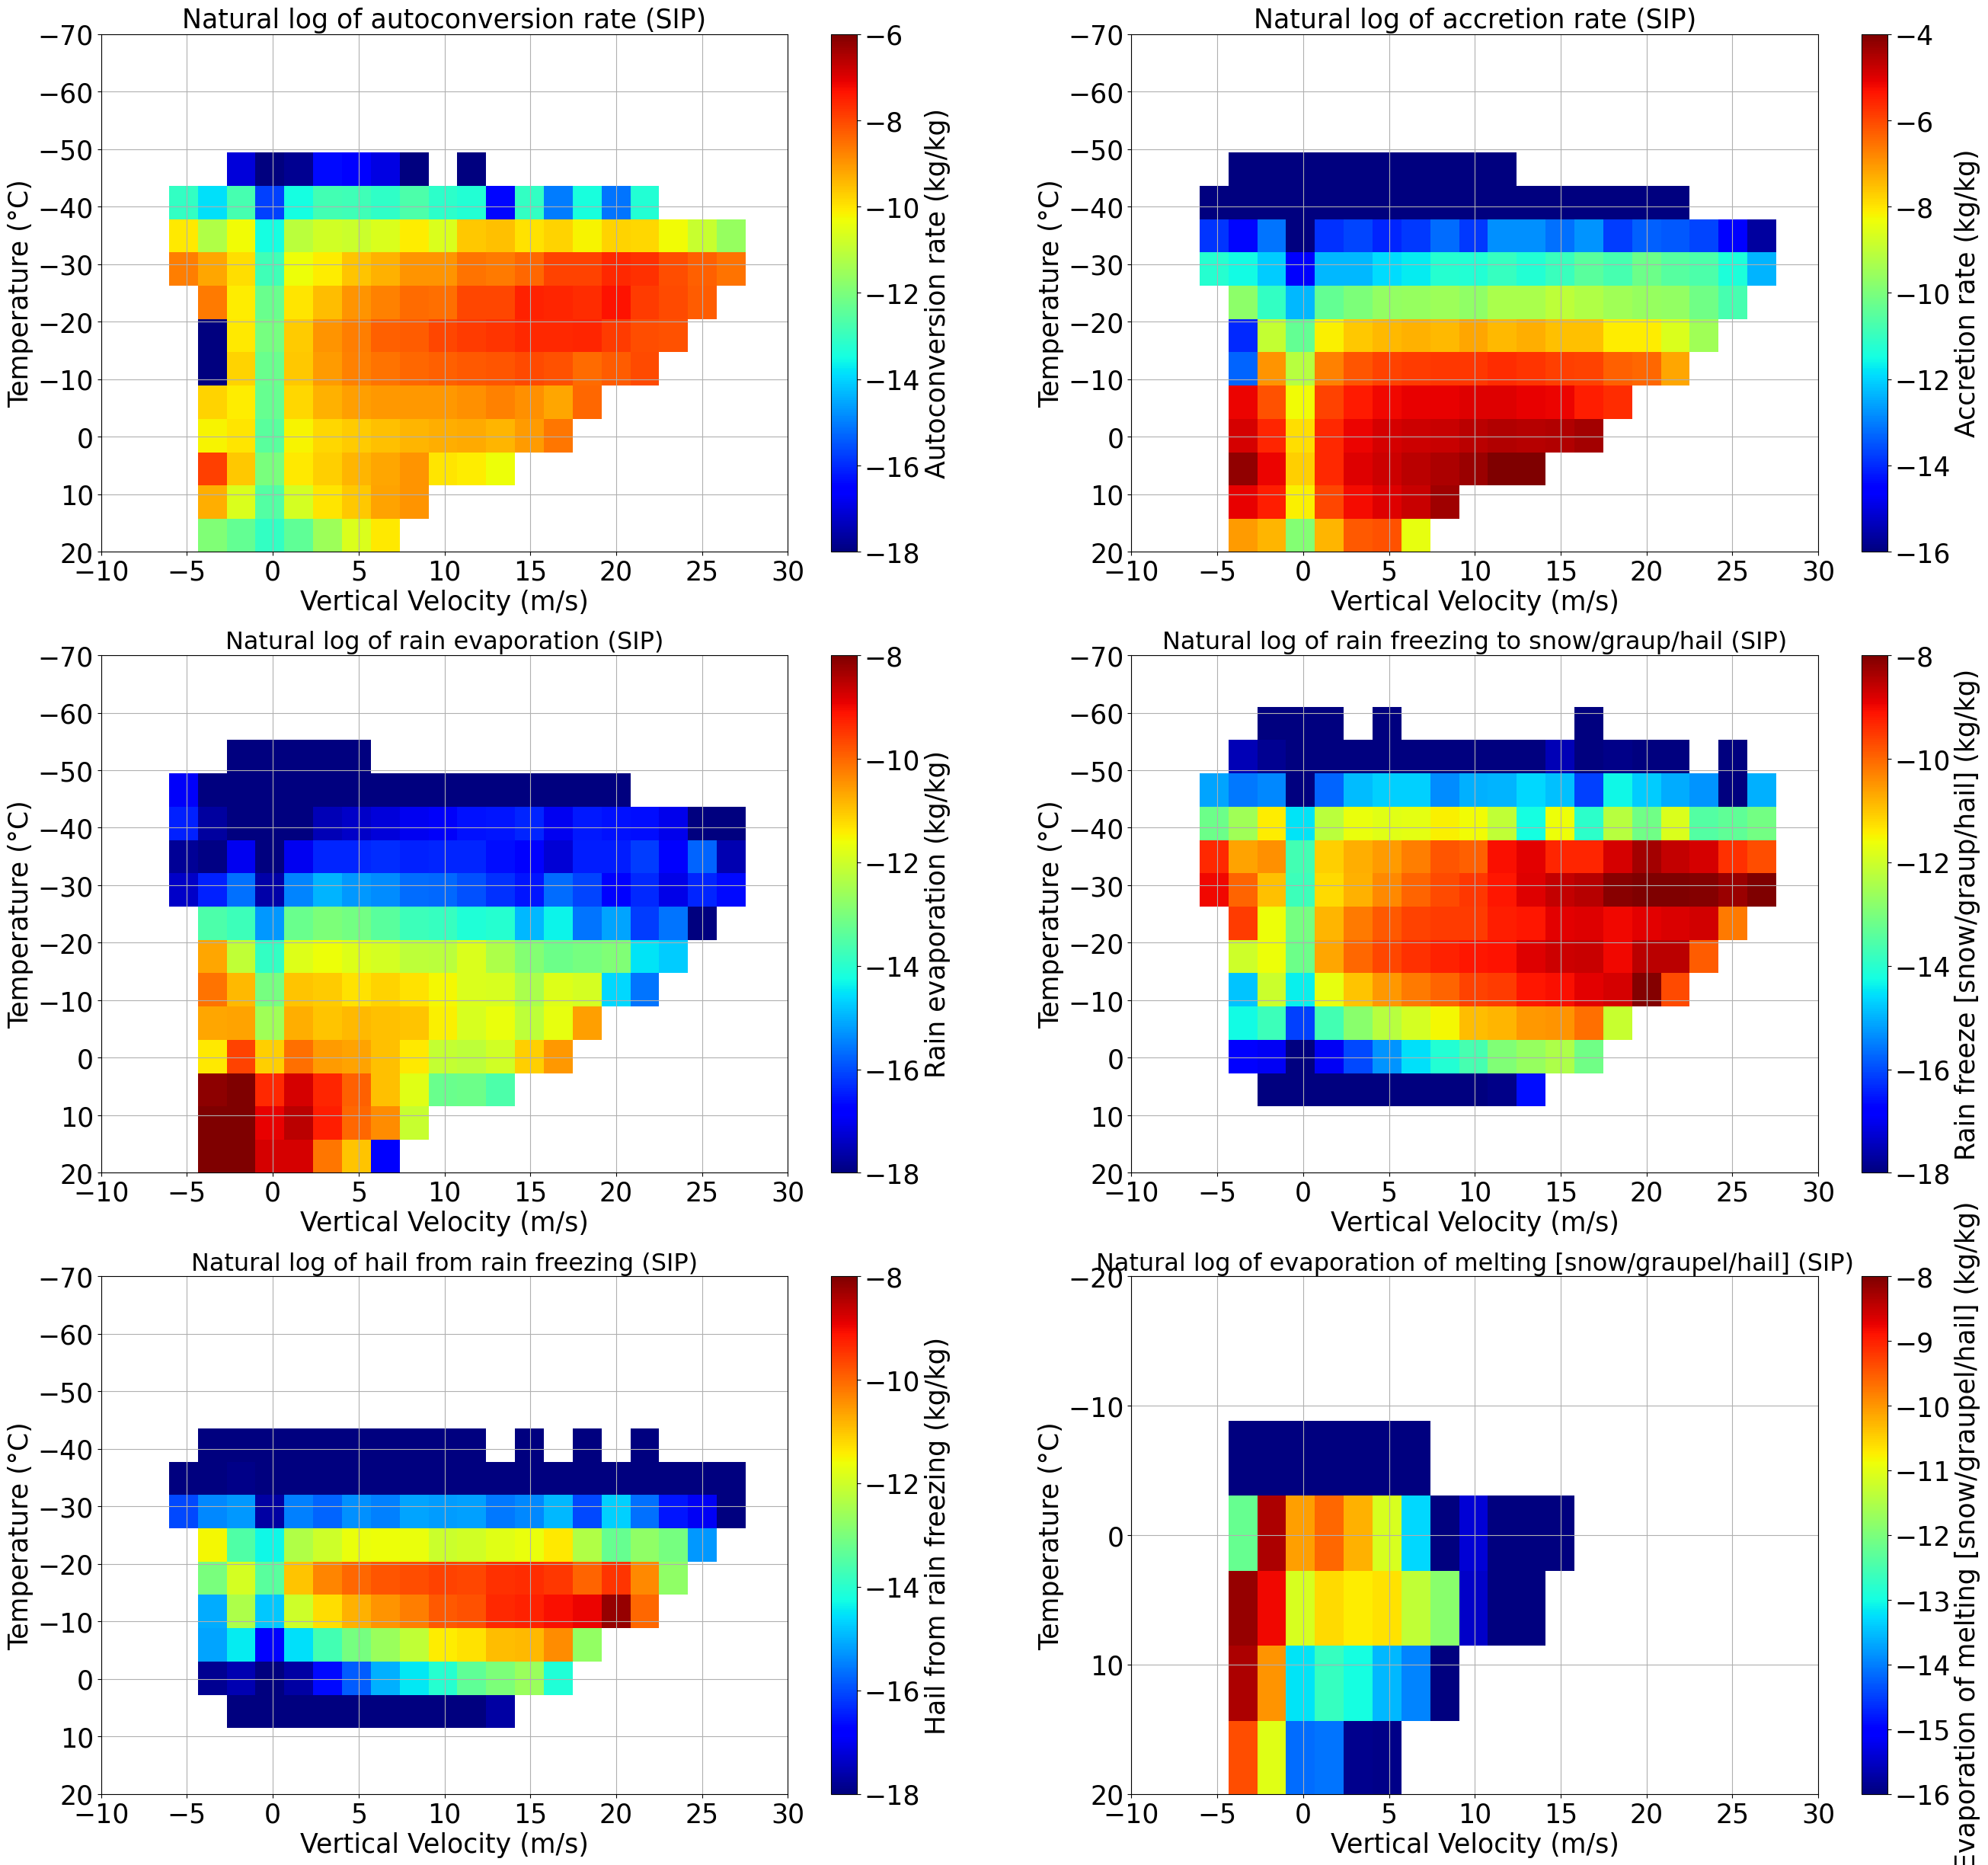

In [119]:


fontsize = 25;

plt.figure(figsize=(32, 30))
plt.subplot(3,2,1)
contour=plt.imshow(np.log(avg_qr_ac_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-18, vmax=-6, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Autoconversion rate (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Autoconversion rate (kg/kg)', size=fontsize)

plt.title('Natural log of autoconversion rate (SIP)', fontsize=fontsize)

plt.subplot(3,2,2)
contour=plt.imshow(np.log(avg_qr_acc_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-16, vmax=-4, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Accretion rate (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Accretion rate (kg/kg)', size=fontsize)

plt.title('Natural log of accretion rate (SIP)', fontsize=fontsize)


plt.subplot(3,2,3)
contour=plt.imshow(np.log(avg_qr_evap_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-18, vmax=-8, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Rain evaporation (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Rain evaporation (kg/kg)', size=fontsize)

plt.title('Natural log of rain evaporation (SIP)', fontsize=fontsize-2)

plt.subplot(3,2,4)
contour=plt.imshow(np.log(avg_qr_rf_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-18, vmax=-8, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Rain freeze [snow/graup/hail] (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Rain freeze [snow/graup/hail] (kg/kg)', size=fontsize)

plt.title('Natural log of rain freezing to snow/graup/hail (SIP)', fontsize=fontsize-2)


plt.subplot(3,2,5)
contour=plt.imshow(np.log(avg_qh_rf_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-18, vmax=-8, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Hail from rain freezing (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Hail from rain freezing (kg/kg)', size=fontsize)

plt.title('Natural log of hail from rain freezing (SIP)', fontsize=fontsize-2)

plt.subplot(3,2,6)
contour=plt.imshow(np.log(avg_qsqh_evap_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-16, vmax=-8, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -20)
plt.yticks([20, 10, 0, -10, -20], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Evaporation of melting [snow/graupel/hail] (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Evaporation of melting [snow/graupel/hail] (kg/kg)', size=fontsize)

plt.title('Natural log of evaporation of melting [snow/graupel/hail] (SIP)', fontsize=fontsize-2)

plt.show()


In [75]:
 
ds_sip

<xarray.Dataset>
Dimensions:        (time: 41, ncells: 68960, vertices: 3, height: 65, bnds: 2,
                    height_2: 66, plev: 1, plev_2: 1, plev_3: 1)
Coordinates:
  * time           (time) datetime64[ns] 2019-09-30 ... 2019-09-30T20:00:00
    clon           (ncells) float64 dask.array<chunksize=(68960,), meta=np.ndarray>
    clat           (ncells) float64 dask.array<chunksize=(68960,), meta=np.ndarray>
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 62.0 63.0 64.0 65.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 63.0 64.0 65.0 66.0
  * plev           (plev) float64 800.0
  * plev_2         (plev_2) float64 400.0
  * plev_3         (plev_3) float64 0.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/78)
    clon_bnds      (time, ncells, vertices) float64 dask.array<chunksize=(1, 68960, 3), meta=np.ndarray>
    clat_bnds      (time, ncells, vertices) float64 dask.array<chunksize=(1, 68960, 3), meta=np.ndarray>
    height_bnds    (time, height, bnds) float64 dask.array<chunksize=(1, 65, 2), meta=np.ndarray>
    plev_bnds      (time, plev, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    plev_2_bnds    (time, plev_2, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    plev_3_bnds    (time, plev_3, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    ...             ...
    lwc_gperm3     (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    ciwc_gperm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    tqi            (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    tiwc_gperm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    cdnc_percm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    inc_perl       (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 2.4.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  99
    uuidOfHGrid:          3eb4f381-adbd-e79a-b32f-6e1ff3ba2860
    uuidOfVGrid:          acbf7b33-d4a3-b631-6ecd-012f775e2bc0
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               version: 2024.10; revision: 885c4646a69d44aa9e9fdf4...
    history:              /home/b/b382718/tdf_sip_lfr/icon-oct2024/bin/icon a...
    references:           see MPIM/DWD publications
    comment:              Deepak Waman (b382718) on l40278 (Linux 4.18.0-513....

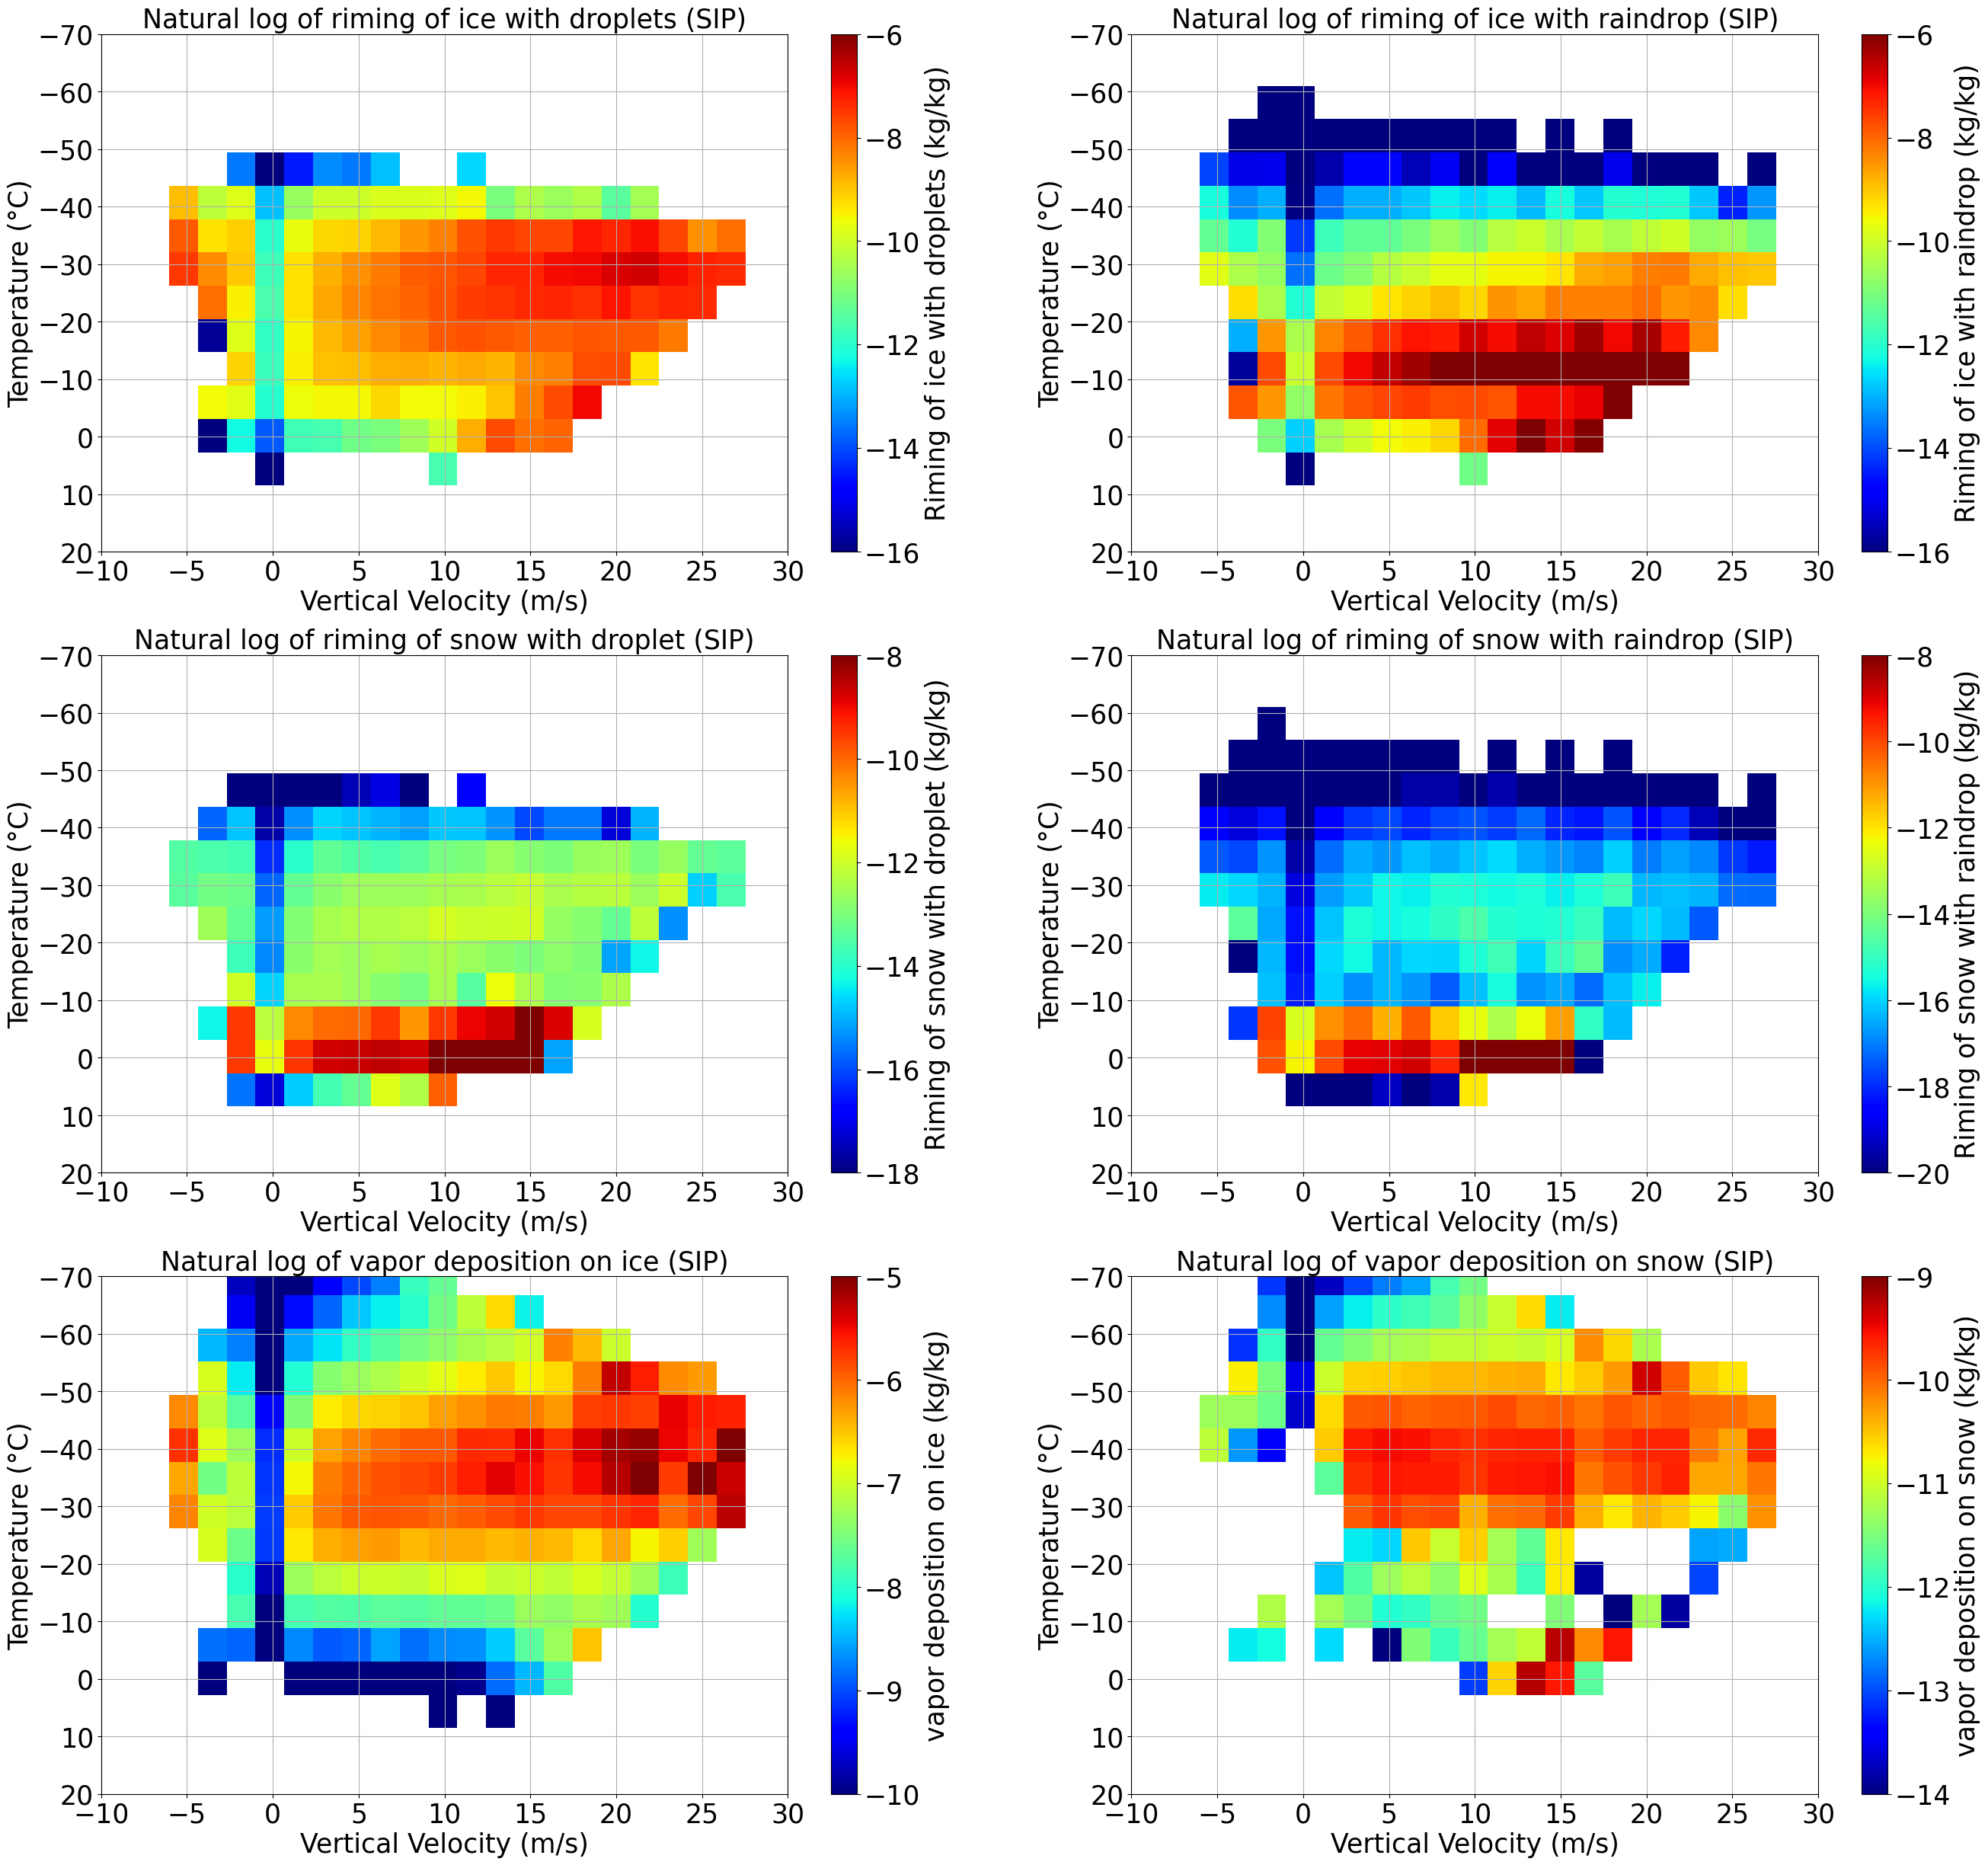

In [120]:


fontsize = 25;

plt.figure(figsize=(32, 30))
plt.subplot(3,2,1)
contour=plt.imshow(np.log(avg_qc_rim_i_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-16, vmax=-6, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Riming of ice with droplets (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Riming of ice with droplets (kg/kg)', size=fontsize)

plt.title('Natural log of riming of ice with droplets (SIP)', fontsize=fontsize)

plt.subplot(3,2,2)
contour=plt.imshow(np.log(avg_qr_rim_i_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-16, vmax=-6, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Riming of ice with raindrop (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Riming of ice with raindrop (kg/kg)', size=fontsize)

plt.title('Natural log of riming of ice with raindrop (SIP)', fontsize=fontsize)


plt.subplot(3,2,3)
contour=plt.imshow(np.log(avg_qc_rim_s_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-18, vmax=-8, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Riming of snow with droplet (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Riming of snow with droplet (kg/kg)', size=fontsize)

plt.title('Natural log of riming of snow with droplet (SIP)', fontsize=fontsize)

plt.subplot(3,2,4)
contour=plt.imshow(np.log(avg_qr_rim_s_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-20, vmax=-8, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Riming of snow with raindrop (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Riming of snow with raindrop (kg/kg)', size=fontsize)

plt.title('Natural log of riming of snow with raindrop (SIP)', fontsize=fontsize)


plt.subplot(3,2,5)
contour=plt.imshow(np.log(avg_qi_dep_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-10, vmax=-5, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='vapor deposition on ice (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='vapor deposition on ice (kg/kg)', size=fontsize)

plt.title('Natural log of vapor deposition on ice (SIP)', fontsize=fontsize)

plt.subplot(3,2,6)
contour=plt.imshow(np.log(avg_qs_dep_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-14, vmax=-9, aspect='auto', origin='lower',cmap='jet') #vmin=1.e-8, vmax=1.e-4, aspect='auto', origin='lower',cmap='jet')
plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='vapor deposition on snow (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='vapor deposition on snow (kg/kg)', size=fontsize)

plt.title('Natural log of vapor deposition on snow (SIP)', fontsize=fontsize)

plt.show()


In [125]:
ds_sip

<xarray.Dataset>
Dimensions:        (time: 41, ncells: 68960, vertices: 3, height: 65, bnds: 2,
                    height_2: 66, plev: 1, plev_2: 1, plev_3: 1)
Coordinates:
  * time           (time) datetime64[ns] 2019-09-30 ... 2019-09-30T20:00:00
    clon           (ncells) float64 dask.array<chunksize=(68960,), meta=np.ndarray>
    clat           (ncells) float64 dask.array<chunksize=(68960,), meta=np.ndarray>
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 62.0 63.0 64.0 65.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 63.0 64.0 65.0 66.0
  * plev           (plev) float64 800.0
  * plev_2         (plev_2) float64 400.0
  * plev_3         (plev_3) float64 0.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/78)
    clon_bnds      (time, ncells, vertices) float64 dask.array<chunksize=(1, 68960, 3), meta=np.ndarray>
    clat_bnds      (time, ncells, vertices) float64 dask.array<chunksize=(1, 68960, 3), meta=np.ndarray>
    height_bnds    (time, height, bnds) float64 dask.array<chunksize=(1, 65, 2), meta=np.ndarray>
    plev_bnds      (time, plev, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    plev_2_bnds    (time, plev_2, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    plev_3_bnds    (time, plev_3, bnds) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    ...             ...
    lwc_gperm3     (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    ciwc_gperm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    tqi            (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    tiwc_gperm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    cdnc_percm3    (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
    inc_perl       (time, height, ncells) float32 dask.array<chunksize=(1, 65, 68960), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 2.4.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  99
    uuidOfHGrid:          3eb4f381-adbd-e79a-b32f-6e1ff3ba2860
    uuidOfVGrid:          acbf7b33-d4a3-b631-6ecd-012f775e2bc0
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               version: 2024.10; revision: 885c4646a69d44aa9e9fdf4...
    history:              /home/b/b382718/tdf_sip_lfr/icon-oct2024/bin/icon a...
    references:           see MPIM/DWD publications
    comment:              Deepak Waman (b382718) on l40278 (Linux 4.18.0-513....

Text(0.5, 1.0, 'Natural log of Hom & Het freezing (SIP)')

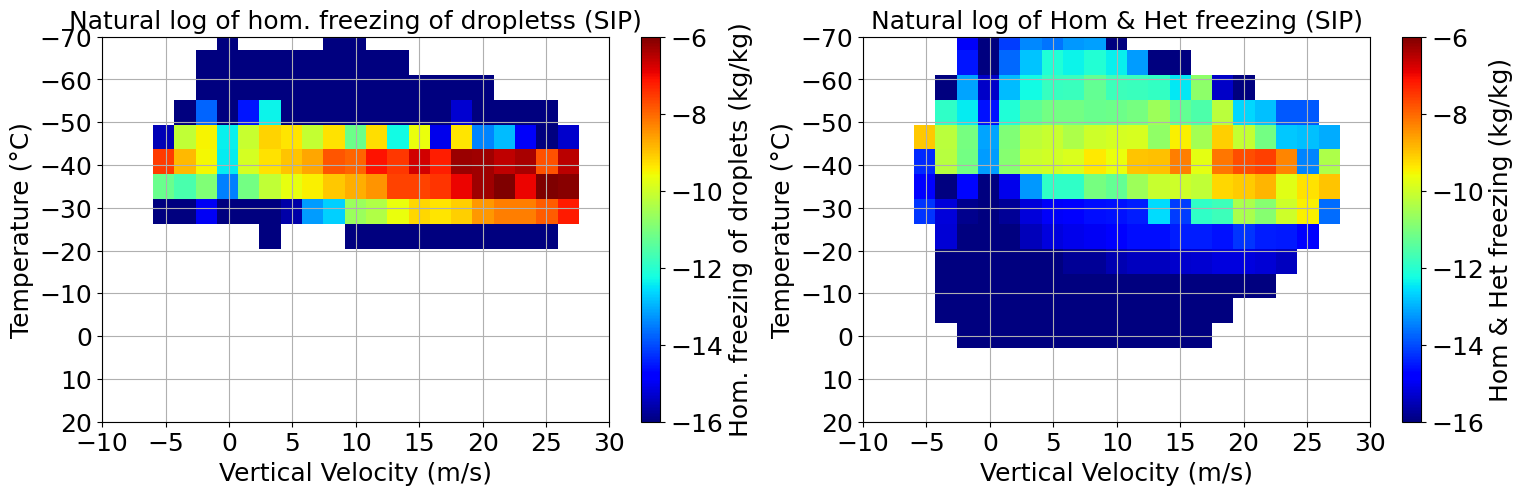

In [126]:

fontsize = 18;

plt.figure(figsize=(18, 5))
plt.subplot(1,2,1)
contour=plt.imshow(np.log(avg_qi_hom_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-16, vmax=-6, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Hom. freezing of droplets (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Hom. freezing of droplets (kg/kg)', size=fontsize)

plt.title('Natural log of hom. freezing of droplets (SIP)', fontsize=fontsize)

plt.subplot(1,2,2)
contour=plt.imshow(np.log(avg_qi_homhet_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-16, vmax=-6, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Hom & Het freezing (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Hom & Het freezing (kg/kg)', size=fontsize)

plt.title('Natural log of Hom & Het freezing (SIP)', fontsize=fontsize)

Text(0.5, 1.0, 'Natural log of Cloud nucleation rate (SIP)')

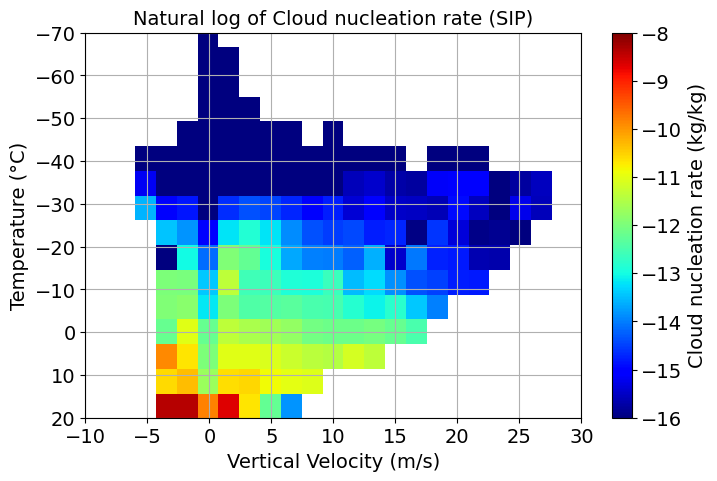

In [132]:
fontsize = 14;

plt.figure(figsize=(8, 5))
contour=plt.imshow(np.log(avg_qc_nuc_temp_w_sip), extent=[wvel_bin[0], wvel_bin[-1],temp_bin[0], temp_bin[-1]], 
                   vmin=-16, vmax=-8, aspect='auto', origin='lower',cmap='jet')

plt.grid(True)
plt.xlim(-10, 30)
plt.xticks([-10, -5, 0, 5, 10, 15, 20, 25, 30], fontsize=fontsize)
plt.ylim(20, -70)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.ylabel('Temperature (°C)', fontsize=fontsize)
plt.xlabel('Vertical Velocity (m/s)', fontsize=fontsize)

colorbar=plt.colorbar(label='Cloud nucleation rate (kg/kg)')
colorbar.ax.tick_params(labelsize=fontsize)
colorbar.set_label(label='Cloud nucleation rate (kg/kg)', size=fontsize)

plt.title('Natural log of Cloud nucleation rate (SIP)', fontsize=fontsize)